In [479]:
# Data 205 - Capstone in Data Science
# Jennifer Paraboschi     Fall 2020
# Inputs: data sets from dataMontgomery
# focusing on Alcohol Beverage Licensing Violations
# Visualization and Analysis of Alcoholic Beverage License Violations, 2016-2020 (Montgomery County, MD)

In [480]:
# Import packages. 
import json
import numpy as np
import pandas as pd
import re
import requests
import seaborn as sns
import matplotlib.pyplot as plt
import plotly    
import plotly.express as px
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison as multi
import scipy.stats as stats

In [481]:
# Pull in API data set as json.
violations_data = pd.read_json("https://data.montgomerycountymd.gov/resource/4tja-rkhg.json")
violations_data.head()

facilityname  \
0  AMY TEX MEX BAR & GRILL   
1          EL CARACOL CAFE   
2               A.C. GRILL   
3     ANTOJITOS RESTAURANT   
4   CANCUN MEXICAN CUISINE   

                                                   address  \
0        621 SLIGO AVE. , SILVER SPRING , MARYLAND - 20910   
1         609 SLIGO AVE , SILVER SPRING , MARYLAND - 20910   
2  293 MUDDY BRANCH ROAD , GAITHERSBURG , MARYLAND - 20878   
3   12 EAST DIAMOND AVE. , GAITHERSBURG , MARYLAND - 20877   
4   117 EAST DIAMOND AVE , GAITHERSBURG , MARYLAND - 20877   

             violationdate  \
0  2020-10-31T00:00:00.000   
1  2020-10-31T00:00:00.000   
2  2020-10-29T00:00:00.000   
3  2020-10-25T00:00:00.000   
4  2020-10-25T00:00:00.000   

                                                                                         violation  \
0                                     6.4 CONSUMPTION, POSSESSION, OR SALE DURING PROHIBITED HOURS   
1                                                                        5.10 DISPENSING OF LIQUOR   
2                                                              5.4 ALCOHOL AWARENESS CERTIFICATION   
3  6.2 SALES OR SERVICE TO INTOXICATED PERSONS/CONSUMPTION OR POSSESSION BY\n\nINTOXICATED PERSONS   
4                                           6.8 ALCOHOLIC BEVERAGE CONTAINERS- REFILLING/TAMPERING   

    disposition          dispositiondate  
0  $1000 +ALERT  2021-01-08T00:00:00.000  
1  $1000 +ALERT  2021-01-08T00:00:00.000  
2   $100 +ALERT  2021-01-08T00:00:00.000  
3  $1000 +ALERT  2021-01-08T00:00:00.000  
4   $200 +ALERT  2021-01-08T00:00:00.000

In [482]:
violations_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   facilityname     950 non-null    object
 1   address          950 non-null    object
 2   violationdate    950 non-null    object
 3   violation        950 non-null    object
 4   disposition      948 non-null    object
 5   dispositiondate  947 non-null    object
dtypes: object(6)
memory usage: 44.7+ KB


In [483]:
# Change the dates so they are in a useable date format.
violations_data.violationdate = pd.to_datetime(violations_data.violationdate)
violations_data.dispositiondate = pd.to_datetime(violations_data.dispositiondate)

In [484]:
violations_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   facilityname     950 non-null    object        
 1   address          950 non-null    object        
 2   violationdate    950 non-null    datetime64[ns]
 3   violation        950 non-null    object        
 4   disposition      948 non-null    object        
 5   dispositiondate  947 non-null    datetime64[ns]
dtypes: datetime64[ns](2), object(4)
memory usage: 44.7+ KB


In [485]:
violations_data.describe(include="all")

facilityname  \
count                        950   
unique                       548   
top     GAITHERSBURG SUPERMARKET   
freq                          11   
first                        NaN   
last                         NaN   

                                                 address        violationdate  \
count                                                950                  950   
unique                                               586                  344   
top     220 EAST DIAMOND AVENUE , GAITHERSBURG, MD 20877  2018-08-17 00:00:00   
freq                                                  11                   16   
first                                                NaN  2012-06-19 00:00:00   
last                                                 NaN  2020-10-31 00:00:00   

            violation                disposition      dispositiondate  
count             950                        948                  947  
unique             40                        146                  409  
top     SALE TO MINOR  SETTLED; $1000.00 + ALERT  2020-09-11 00:00:00  
freq              381                         96                   18  
first             NaN                        NaN  2016-01-19 00:00:00  
last              NaN                        NaN  2021-01-08 00:00:00

In [486]:
# There are a few missing values for disposition and disposition date (counts are fewer than total count in some columns).
# The most frequent violation is for sale to minor.

In [487]:
violations_data.isnull().sum()
# This gives the number of null values for each var.

facilityname       0
address            0
violationdate      0
violation          0
disposition        2
dispositiondate    3
dtype: int64

In [488]:
violations_data.nunique()
# This gives the number of unique values for each variable

facilityname       548
address            586
violationdate      344
violation           40
disposition        146
dispositiondate    409
dtype: int64

In [489]:
# Provide a list of the violations as an array.
violations_data.violation.unique()

array(['6.4 CONSUMPTION, POSSESSION, OR SALE DURING PROHIBITED HOURS',
       '5.10 DISPENSING OF LIQUOR', '5.4 ALCOHOL AWARENESS CERTIFICATION',
       '6.2 SALES OR SERVICE TO INTOXICATED PERSONS/CONSUMPTION OR POSSESSION BY\n\nINTOXICATED PERSONS',
       '6.8 ALCOHOLIC BEVERAGE CONTAINERS- REFILLING/TAMPERING',
       '5.5 RECORDS', '5.7 DISPLAY OF LICENSE', '6.9 STORAGE',
       '6.1 SALES OR SERVICE TO MINORS/CONSUMPTION OR POSSESSION OF MINORS',
       '5.2 CHANGES IN LICENSING INFORMATION', 'NO VIOLATION',
       '6.3 AGES OF EMPLOYEES',
       'EMPLOYEE RECORDS NOT AVAILABLE WHEN REQUESTED',
       'LICENSE NOT PROPERLY DISPLAYED', 'SALE TO MINOR',
       'ALCOHOL AWARENESS CERTIFIED PERSON NOT ON PREMISES', 'STORAGE',
       'ACTS CONTRARY TO LAW', 'LICENSE COMPLIANCE CHECK',
       "LICENSEES' RESPONSIBILITY",
       'NOISE/DISTURBANCE OF THE NEIGHBORHOOD', 'DISORDERLY HOUSE',
       'DISPENSING LIQUOR BY BOTTLE FOR CONSUMPTION ONSITE',
       'REFILLING EMPTY/PARTIALLY EMPT

In [490]:
# Get counts of the number of violations at each violation type.
violations_data["violation"].value_counts().sort_values(ascending=False)

SALE TO MINOR                                                                                      381
ALCOHOL AWARENESS CERTIFIED PERSON NOT ON PREMISES                                                 173
6.1 SALES OR SERVICE TO MINORS/CONSUMPTION OR POSSESSION OF MINORS                                  66
EMPLOYEE RECORDS NOT AVAILABLE WHEN REQUESTED                                                       64
LICENSE NOT PROPERLY DISPLAYED                                                                      57
RECORDS INVOICE VIOLATION                                                                           27
5.4 ALCOHOL AWARENESS CERTIFICATION                                                                 26
SALE/SERVICE TO INTOXICATED PATRON                                                                  16
STORAGE                                                                                             14
5.5 RECORDS                                                              

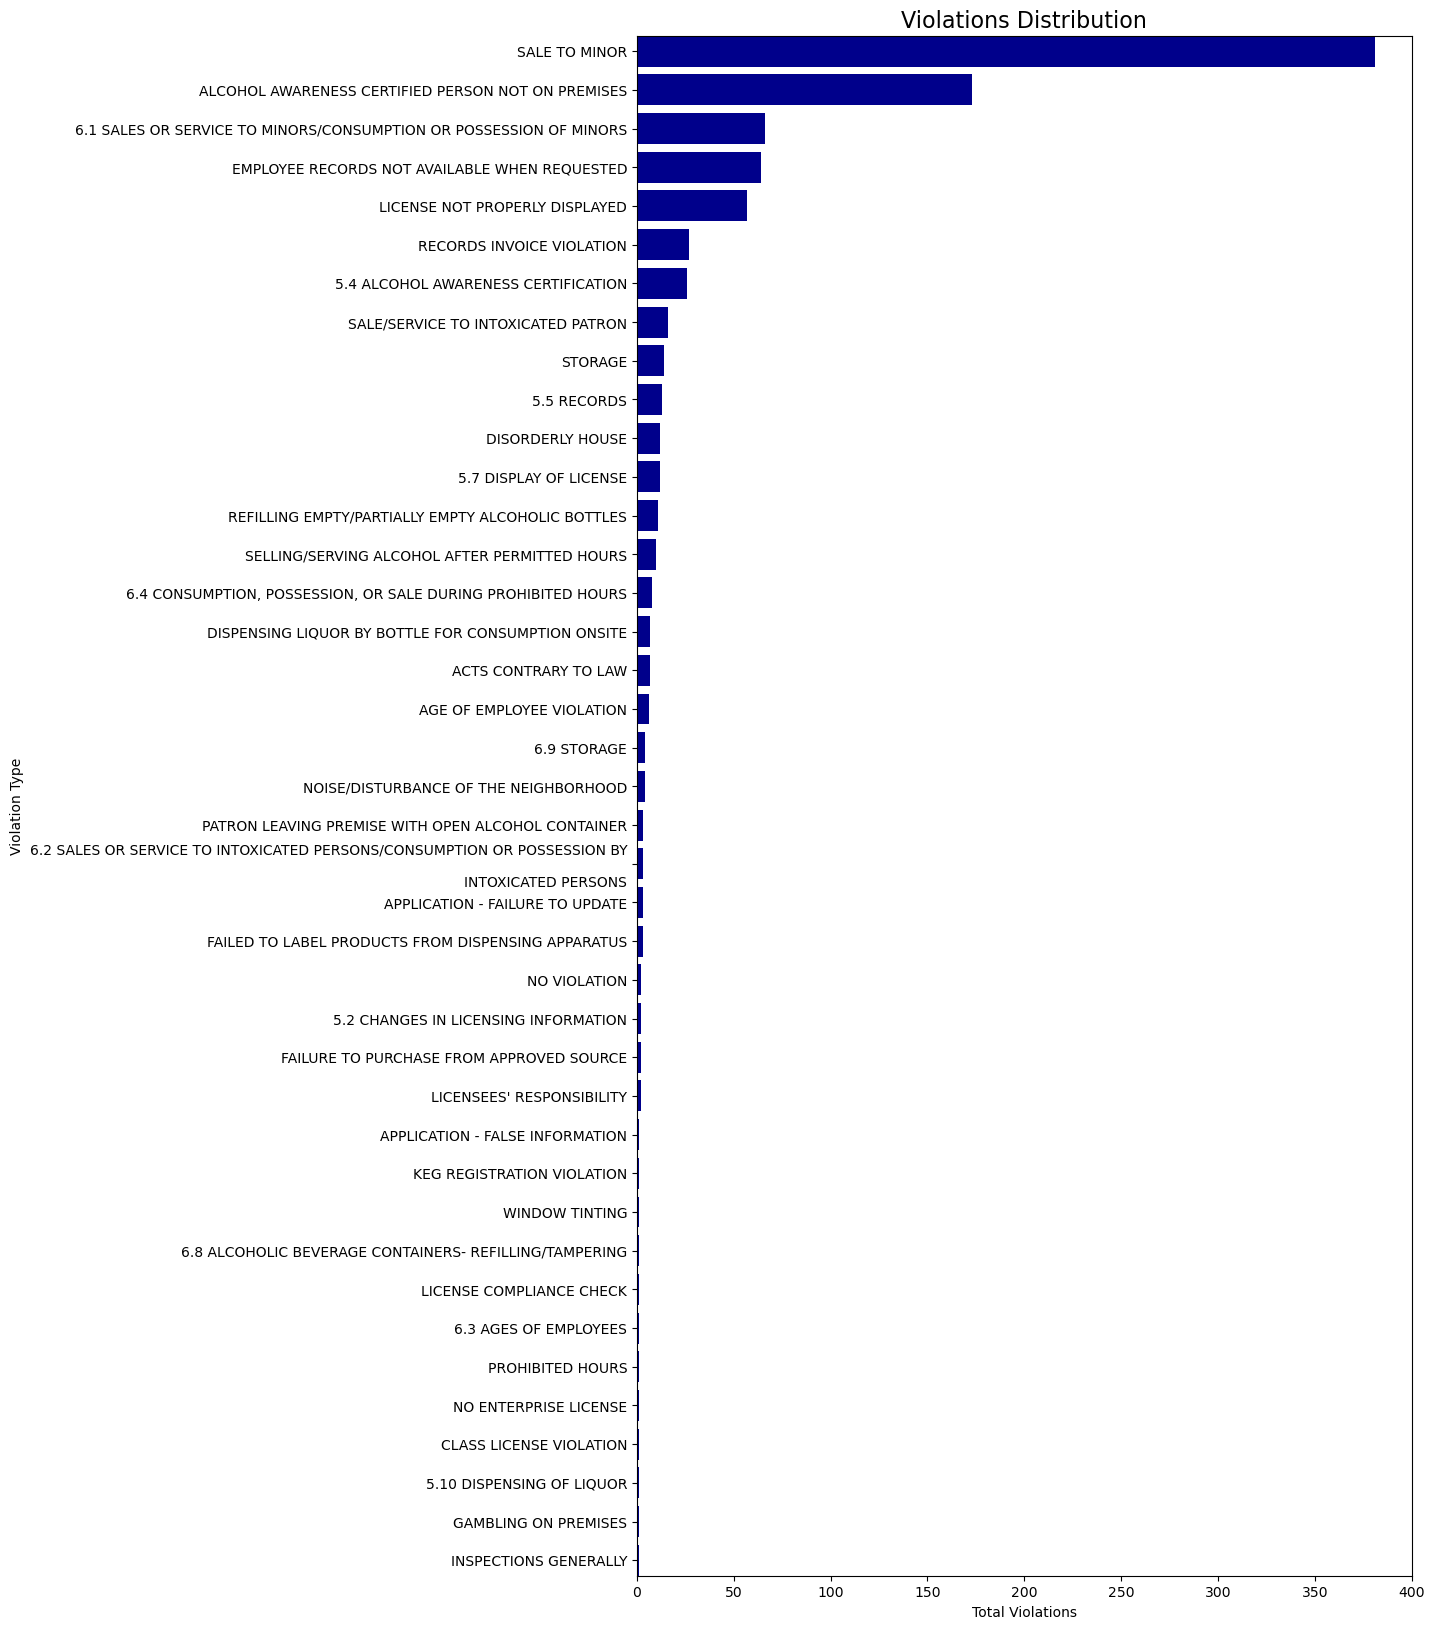

In [491]:
# chart the distribution of the violations
plt.rcdefaults()

violations_dist = violations_data["violation"].value_counts().sort_values()
x = violations_dist.index
y = violations_dist

fig = plt.figure(figsize=(10,20)) 
ax = fig.add_subplot(1,1,1)
ax.barh(x, y, color="darkblue", linewidth=3)
ax.set_title("Violations Distribution", fontsize=16)
ax.set(ylabel="Violation Type", xlabel="Total Violations")
plt.margins(0.05, 0) # eliminates white space at top/bottom of chart
plt.savefig("ViolationsDist.png")
plt.show()


In [492]:
# Remap/Group/Rename the violation categories. 
violation_regrouping = {"5.10 DISPENSING OF LIQUOR": "OTHER",
                        "5.2 CHANGES IN LICENSING INFORMATION": "LICENSE",
                        "5.4 ALCOHOL AWARENESS CERTIFICATION": "ALCOHOL AWARENESS CERTIFICATION",
                        "5.5 RECORDS": "RECORDS",
                        "5.7 DISPLAY OF LICENSE": "LICENSE",
                        "6.1 SALES OR SERVICE TO MINORS/CONSUMPTION OR POSSESSION OF MINORS": "SALE TO MINOR",
                        "6.2 SALES OR SERVICE TO INTOXICATED PERSONS/CONSUMPTION OR POSSESSION BY\n\nINTOXICATED PERSONS": "INTOXICATED PERSONS",
                        "6.3 AGES OF EMPLOYEES": "OTHER",
                        "6.4 CONSUMPTION, POSSESSION, OR SALE DURING PROHIBITED HOURS": "OTHER",
                        "6.8 ALCOHOLIC BEVERAGE CONTAINERS- REFILLING/TAMPERING": "OTHER",
                        "6.9 STORAGE": "STORAGE",
                        "ACTS CONTRARY TO LAW": "OTHER",
                        "AGE OF EMPLOYEE VIOLATION": "OTHER",
                        "ALCOHOL AWARENESS CERTIFIED PERSON NOT ON PREMISES": "ALCOHOL AWARENESS CERTIFICATION",
                        "APPLICATION - FAILURE TO UPDATE": "LICENSE",
                        "APPLICATION - FALSE INFORMATION": "LICENSE",
                        "CLASS LICENSE VIOLATION": "LICENSE",
                        "DISORDERLY HOUSE": "OTHER",
                        "DISPENSING LIQUOR BY BOTTLE FOR CONSUMPTION ONSITE": "OTHER",
                        "EMPLOYEE RECORDS NOT AVAILABLE WHEN REQUESTED": "RECORDS",
                        "FAILED TO LABEL PRODUCTS FROM DISPENSING APPARATUS": "OTHER",
                        "FAILURE TO PURCHASE FROM APPROVED SOURCE": "STORAGE",
                        "GAMBLING ON PREMISES": "LICENSE",
                        "INSPECTIONS GENERALLY": "LICENSE",
                        "KEG REGISTRATION VIOLATION": "LICENSE",
                        "LICENSE COMPLIANCE CHECK": "LICENSE",
                        "LICENSE NOT PROPERLY DISPLAYED": "LICENSE",
                        "LICENSEES' RESPONSIBILITY": "LICENSE",
                        "NO ENTERPRISE LICENSE": "LICENSE",
                        "NO VIOLATION": "OTHER",
                        "NOISE/DISTURBANCE OF THE NEIGHBORHOOD": "OTHER",
                        "PATRON LEAVING PREMISE WITH OPEN ALCOHOL CONTAINER": "OPEN CONTAINER",
                        "PROHIBITED HOURS": "OTHER",
                        "RECORDS INVOICE VIOLATION": "RECORDS",
                        "REFILLING EMPTY/PARTIALLY EMPTY ALCOHOLIC BOTTLES": "OPEN CONTAINER",
                        "SALE TO MINOR": "SALE TO MINOR",
                        "SALE/SERVICE TO INTOXICATED PATRON": "INTOXICATED PERSONS",
                        "SELLING/SERVING ALCOHOL AFTER PERMITTED HOURS": "OTHER",
                        "STORAGE": "STORAGE",
                        "WINDOW TINTING": "LICENSE"
                       }
 

In [493]:
violations_data["violation"] = violations_data["violation"].map(violation_regrouping)
# Get counts of the number of violations at each violation grouping.
violations_data["violation"].value_counts().sort_values(ascending=False)

SALE TO MINOR                      447
ALCOHOL AWARENESS CERTIFICATION    199
RECORDS                            104
LICENSE                             84
OTHER                               63
STORAGE                             20
INTOXICATED PERSONS                 19
OPEN CONTAINER                      14
Name: violation, dtype: int64

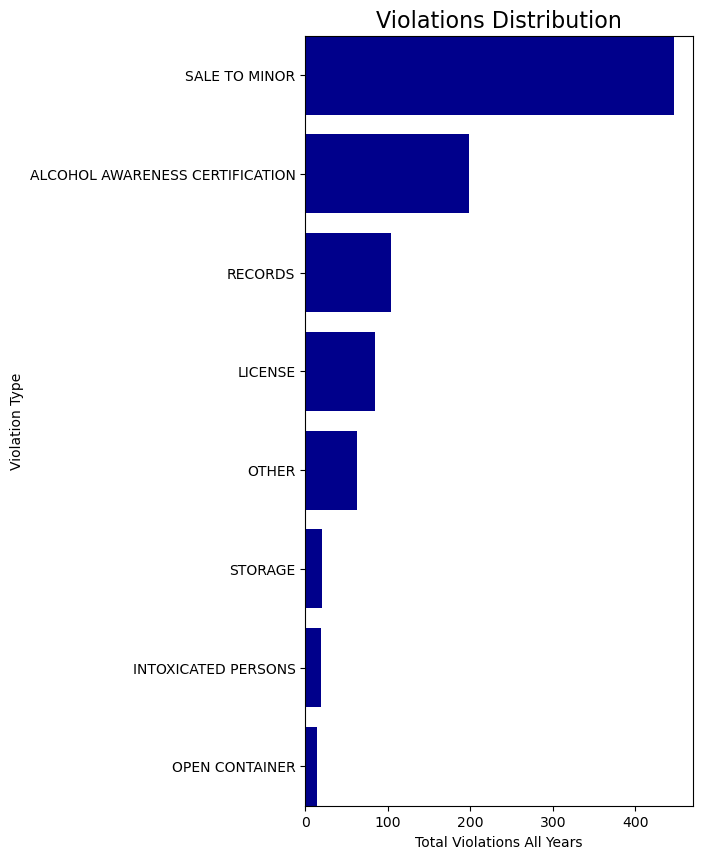

In [494]:
# chart the distribution of the reclassed violations
plt.rcdefaults()

violations_dist = violations_data["violation"].value_counts().sort_values()
x = violations_dist.index
y = violations_dist

fig = plt.figure(figsize=(5,10)) 
ax = fig.add_subplot(1,1,1)
ax.barh(x, y, color="darkblue", linewidth=3)
ax.set_title("Violations Distribution", fontsize=16)
ax.set(ylabel="Violation Type", xlabel="Total Violations All Years")
plt.margins(0.05, 0) # eliminates white space at top/bottom of chart
plt.savefig("ViolationsDist2.png")
plt.show()

In [495]:
# Get counts of the number of violations at each facility name.
pd.set_option("display.max_rows", None)
violations_data["facilityname"].value_counts().sort_values(ascending=False)

GAITHERSBURG SUPERMARKET                           11
CAFE 20/20                                          8
KALDI'S COFFEE                                      8
MOGOTILLO RESTAURANT                                6
RESTAURANT POLLOS EL MESON                          6
AKIRA RAMEN IZAKAYA                                 6
PANDORA SEAFOOD HOUSE                               6
GENTLEMAN JIM'S RESTAURANT                          6
BAR LOUIE                                           6
OUTBACK STEAKHOUSE                                  5
MIX BAR & GRILLE                                    5
SUPER CHICKEN                                       5
KAYPI RESTAURANT                                    5
TACO BAR                                            5
TRAPEZARIA MEDITERRANEAN KUZINA                     5
CANCUN MEXICAN CUISINE                              5
FUSION BAR & GRILL                                  5
OGEI'S CHICKEN & SUBS                               5
CHIPOTLE MEXICAN GRILL      

In [496]:
# Gaithersburg Supermarket has had the greatest number of violations. 
violations_data[violations_data.facilityname == "GAITHERSBURG SUPERMARKET"]

facilityname  \
161  GAITHERSBURG SUPERMARKET   
198  GAITHERSBURG SUPERMARKET   
199  GAITHERSBURG SUPERMARKET   
200  GAITHERSBURG SUPERMARKET   
227  GAITHERSBURG SUPERMARKET   
228  GAITHERSBURG SUPERMARKET   
229  GAITHERSBURG SUPERMARKET   
698  GAITHERSBURG SUPERMARKET   
841  GAITHERSBURG SUPERMARKET   
842  GAITHERSBURG SUPERMARKET   
843  GAITHERSBURG SUPERMARKET   

                                              address violationdate  \
161  220 EAST DIAMOND AVENUE , GAITHERSBURG, MD 20877    2019-09-24   
198  220 EAST DIAMOND AVENUE , GAITHERSBURG, MD 20877    2019-08-01   
199  220 EAST DIAMOND AVENUE , GAITHERSBURG, MD 20877    2019-08-01   
200  220 EAST DIAMOND AVENUE , GAITHERSBURG, MD 20877    2019-08-01   
227  220 EAST DIAMOND AVENUE , GAITHERSBURG, MD 20877    2019-06-05   
228  220 EAST DIAMOND AVENUE , GAITHERSBURG, MD 20877    2019-06-05   
229  220 EAST DIAMOND AVENUE , GAITHERSBURG, MD 20877    2019-06-05   
698  220 EAST DIAMOND AVENUE , GAITHERSBURG, MD 20877    2017-04-03   
841  220 EAST DIAMOND AVENUE , GAITHERSBURG, MD 20877    2016-06-09   
842  220 EAST DIAMOND AVENUE , GAITHERSBURG, MD 20877    2016-06-09   
843  220 EAST DIAMOND AVENUE , GAITHERSBURG, MD 20877    2016-06-09   

                           violation  \
161  ALCOHOL AWARENESS CERTIFICATION   
198  ALCOHOL AWARENESS CERTIFICATION   
199                          LICENSE   
200                          RECORDS   
227                          RECORDS   
228  ALCOHOL AWARENESS CERTIFICATION   
229                          RECORDS   
698  ALCOHOL AWARENESS CERTIFICATION   
841                    SALE TO MINOR   
842                          RECORDS   
843  ALCOHOL AWARENESS CERTIFICATION   

                                                     disposition  \
161  2 WEEK SUSPENSION STARTING FROM JANUARY 20- FEBRUARY 9,2020   
198       2 WEEK SUSPENSION + ALERT (OCTOBER 9-OCTOBER 22, 2019)   
199                                           SETTLED;$100+ALERT   
200                                           SETTLED;$500+ALERT   
227                                                   $500+ALERT   
228                                         SETTLED;$500 + ALERT   
229                                          SETTLED;$500+ ALERT   
698                                     SETTLED; $500.00 + ALERT   
841                                    SETTLED; $1000.00 + ALERT   
842                                     SETTLED; $500.00 + ALERT   
843                                     SETTLED; $100.00 + ALERT   

    dispositiondate  
161      2019-09-24  
198      2019-08-01  
199      2019-08-01  
200      2019-08-01  
227      2019-06-05  
228      2019-06-05  
229      2019-09-09  
698      2017-06-05  
841      2016-08-16  
842      2016-07-28  
843      2016-08-19

In [497]:
"""
Explore the penalties for the violations
"""

'\nExplore the penalties for the violations\n'

In [498]:
# Determine the unique values in the disposition.
violations_data['disposition'].unique()

array(['$1000 +ALERT', '$100 +ALERT', '$200 +ALERT', '$500 +ALERT',
       'SETTLED $100 +ALERT', '$1600 +ALERT', 'SETTLED $400 +ALERT',
       '$2500 +ALERT', 'SETTLED $1000 +ALERT', '$0 +ALERT',
       'SETTLED $2500 +ALERT', 'SETTLED $500 +ALERT', nan,
       'SETTLED $2600 +ALERT', 'SETTLED;$500+ALERT', 'SETTLED;$100+ALERT',
       'SETTLED;$1000+ALERT', '$1000+ALERT', 'SETTLED;100+ALERT',
       '$100+ALERT', '$2500+ALERT', 'SETTLED;$2800+ALERT', '500+ALERT',
       'SETTLED;$2500+ALERT',
       '2 WEEK SUSPENSION STARTING FROM JANUARY 20- FEBRUARY 9,2020',
       '2 DAY SUSPENSION FROM DECEMBER 23-24, 2019',
       '2 WEEK SUSPENSION STARTING FROM JANUARY 6-JANUARY 19,2020',
       '2 WEEK SUSPENSION FROM JANUARY 6-JANUARY 19, 2020',
       'SETTLED;$600+ALERT', 'SETTELD;$100+ALERT',
       '2 WEEK SUSPENSION + ALERT (OCTOBER 9-OCTOBER 22, 2019)',
       'WARNING', '10 DAY SUSPENSION; NOVEMBER 20-NOVEMBER 29, 2019',
       'SETTLED;$2900+ALERT', 'SETTLED;$100.00+ALERT',
       'S

In [499]:
# The disposition var inconsistently contains a dollar amount of the penalty with inconsistent formatting. 
# Use a regex to extract the penalty values.

violations_data["penalty"]=violations_data["disposition"].str.extract(r"((?<=\$)?\d+,?\d{2,})")

In [500]:
violations_data[["penalty", "disposition"]] # checking that the penalty amounts pulled in correctly.

penalty  \
0       1000   
1       1000   
2        100   
3       1000   
4        200   
5       1000   
6       1000   
7        500   
8        100   
9        500   
10       100   
11      1600   
12       400   
13       500   
14       100   
15       500   
16      1000   
17      1000   
18       100   
19       500   
20       100   
21      2500   
22      1000   
23      1000   
24      1000   
25      1000   
26       NaN   
27      1000   
28       100   
29      2500   
30      2500   
31      1000   
32       500   
33       100   
34      1000   
35      1000   
36       500   
37       500   
38      2500   
39      1000   
40      1000   
41      1000   
42      1000   
43       500   
44      1000   
45      2500   
46      1000   
47      1000   
48       500   
49       500   
50       100   
51       100   
52      1000   
53      1000   
54       NaN   
55      1000   
56      1000   
57       100   
58       500   
59      2500   
60       100   
61       100   
62       100   
63      1000   
64       NaN   
65      1000   
66      2500   
67       500   
68       100   
69       100   
70      1000   
71      1000   
72       500   
73      1000   
74      1000   
75       100   
76       500   
77      1000   
78       100   
79       500   
80       100   
81       500   
82       200   
83       100   
84      1000   
85       100   
86      1000   
87      2500   
88      1000   
89      1000   
90      1000   
91      1000   
92      1000   
93       100   
94      1000   
95      1000   
96       100   
97      1000   
98      1000   
99      1000   
100     1000   
101     1000   
102      100   
103     1000   
104      100   
105      100   
106      100   
107     1000   
108     2500   
109     1000   
110     1000   
111     1000   
112     1000   
113     1000   
114     1000   
115     1000   
116     1000   
117      100   
118     1000   
119     1000   
120      500   
121      100   
122     1000   
123      500   
124      500   
125      NaN   
126      500   
127      500   
128     2600   
129     1000   
130      500   
131     1000   
132     1000   
133      100   
134      500   
135      100   
136     1000   
137     1000   
138     1000   
139      100   
140      100   
141     1000   
142     1000   
143      100   
144      100   
145     2500   
146      500   
147     2800   
148     1000   
149      500   
150      100   
151     2500   
152     2500   
153      100   
154      500   
155      100   
156     1000   
157      100   
158     1000   
159      100   
160      500   
161   9,2020   
162     2019   
163      100   
164      100   
165  19,2020   
166     2020   
167  19,2020   
168  19,2020   
169  19,2020   
170     1000   
171     1000   
172     1000   
173     1000   
174      100   
175     2500   
176      500   
177      100   
178      100   
179      600   
180      100   
181      100   
182      100   
183      100   
184      100   
185      500   
186     1000   
187      100   
188      100   
189     1000   
190     1000   
191     1000   
192     1000   
193      100   
194      100   
195      500   
196     1000   
197     1000   
198     2019   
199      100   
200      500   
201      NaN   
202     2019   
203     2019   
204     2900   
205      100   
206      500   
207      500   
208      100   
209      100   
210      100   
211      500   
212      100   
213      400   
214      500   
215      500   
216      100   
217      100   
218      100   
219      600   
220      100   
221      200   
222     7200   
223     1000   
224      100   
225      400   
226      100   
227      500   
228      500   
229      500   
230     5000   
231     1000   
232     1000   
233      500   
234      200   
235      100   
236      100   
237      100   
238      100   
239      100   
240      100   
241      100   
242      100   
243      100   
244      100   
245      100   
246      100   
247      100   
248      100   
249  

In [501]:
# The penalty requires further cleaning
# Removes the commas from numbers as strings
violations_data["penalty"] = violations_data["penalty"].str.replace(',', '')

# Replace missing penalty values with 0.
violations_data["penalty"]=violations_data["penalty"].fillna(0)

In [502]:
violations_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   facilityname     950 non-null    object        
 1   address          950 non-null    object        
 2   violationdate    950 non-null    datetime64[ns]
 3   violation        950 non-null    object        
 4   disposition      948 non-null    object        
 5   dispositiondate  947 non-null    datetime64[ns]
 6   penalty          950 non-null    object        
dtypes: datetime64[ns](2), object(5)
memory usage: 52.1+ KB


In [503]:
violations_data

facilityname  \
0                            AMY TEX MEX BAR & GRILL   
1                                    EL CARACOL CAFE   
2                                         A.C. GRILL   
3                               ANTOJITOS RESTAURANT   
4                             CANCUN MEXICAN CUISINE   
5                             CANCUN MEXICAN CUISINE   
6                                HAKUNA MATATA GRILL   
7                               MOGOTILLO RESTAURANT   
8                                    EL CARACOL CAFE   
9                               MOGOTILLO RESTAURANT   
10                              MOGOTILLO RESTAURANT   
11                              MOGOTILLO RESTAURANT   
12                           GISELE'S CREOLE CUISINE   
13                            CASPIAN HOUSE OF KABOB   
14                            CASPIAN HOUSE OF KABOB   
15                               VILLAGE WEST LIQUOR   
16                           Q' VIVA COCINA & LOUNGE   
17                         FINNEGAN'S WAKE IRISH PUB   
18                             CUBANO'S RESTAURANT 2   
19                             CUBANO'S RESTAURANT 2   
20                             BLACK'S BAR & KITCHEN   
21                             BLACK'S BAR & KITCHEN   
22                                         BRICKSIDE   
23                               DOG HAUS BIERGARTEN   
24                                             JALEO   
25                                      MON AMI GABI   
26                              TIA QUETA RESTAURANT   
27                                   WOODMONT MARKET   
28                                     KOREAN KORNER   
29                                     KOREAN KORNER   
30                OUTBACK STEAKHOUSE - SILVER SPRING   
31                         RINCON MAGICO BAR & GRILL   
32                         RINCON MAGICO BAR & GRILL   
33                            RODMANS PARTY BOUTIQUE   
34                            RODMANS PARTY BOUTIQUE   
35                          SOLE D'ITALIA RESTAURANT   
36                           SHOPPERS FOOD WAREHOUSE   
37                                            DRYBAR   
38                                 DOLLAR PLUS STORE   
39                               HAKUNA MATATA GRILL   
40                                 STAINED GLASS PUB   
41                                     SUPER CHICKEN   
42                                  CAVA MEZZE-OLNEY   
43                              EMPIRE CAFE & MARKET   
44                                     MANNEQUIN PIS   
45                                      ROOTS MARKET   
46                                     SMOKETOWN BBQ   
47                           THE MANOR AT SILO FALLS   
48                        DENISE MEXICAN BAR & GRILL   
49                                            KABUTO   
50                                        WASABI ZEN   
51                           ARIA, BEER, WINE & DELI   
52                           ARIA, BEER, WINE & DELI   
53                                   BETHESDA MARKET   
54                               LANCE'S BEER & WINE   
55                               LANCE'S BEER & WINE   
56                          PASSION FIN ASIAN BISTRO   
57                          PASSION FIN ASIAN BISTRO   
58                          PASSION FIN ASIAN BISTRO   
59                           PROMENADE MARKET & DELI   
60                                      SUSHI OISHII   
61                                         LA CASITA   
62                                TACO DADDY CANTINA   
63                                       CASA OAXACA   
64                        CHERCHER ETHIOPIAN CUISINE   
65                                HIMALAYAN HERITAGE   
66                            MAMMA LUCIA - BETHESDA   
67                                       MEDIUM RARE   
68                        REDMILL MARKET BEER & WINE   
69                                      THAI CUISINE   
70                                               VUK   
71      

In [504]:
penalty_cleanup = violations_data["penalty"].str.slice(start=-4)
penalty_cleanup

0      1000
1      1000
2       100
3      1000
4       200
5      1000
6      1000
7       500
8       100
9       500
10      100
11     1600
12      400
13      500
14      100
15      500
16     1000
17     1000
18      100
19      500
20      100
21     2500
22     1000
23     1000
24     1000
25     1000
26      NaN
27     1000
28      100
29     2500
30     2500
31     1000
32      500
33      100
34     1000
35     1000
36      500
37      500
38     2500
39     1000
40     1000
41     1000
42     1000
43      500
44     1000
45     2500
46     1000
47     1000
48      500
49      500
50      100
51      100
52     1000
53     1000
54      NaN
55     1000
56     1000
57      100
58      500
59     2500
60      100
61      100
62      100
63     1000
64      NaN
65     1000
66     2500
67      500
68      100
69      100
70     1000
71     1000
72      500
73     1000
74     1000
75      100
76      500
77     1000
78      100
79      500
80      100
81      500
82      200
83  

In [505]:
# corrects for the year values that pulled in as penalty amounts
count = 0
for i in penalty_cleanup.str.slice(start=-4):
    if i == '2019' or i == '2020':
        violations_data['penalty'].iloc[count] = 0
    count+=1

C:\Users\jenni\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [506]:
violations_data[["penalty", 'disposition']] # checking that the penalty amounts pulled in correctly.

penalty  \
0      1000   
1      1000   
2       100   
3      1000   
4       200   
5      1000   
6      1000   
7       500   
8       100   
9       500   
10      100   
11     1600   
12      400   
13      500   
14      100   
15      500   
16     1000   
17     1000   
18      100   
19      500   
20      100   
21     2500   
22     1000   
23     1000   
24     1000   
25     1000   
26        0   
27     1000   
28      100   
29     2500   
30     2500   
31     1000   
32      500   
33      100   
34     1000   
35     1000   
36      500   
37      500   
38     2500   
39     1000   
40     1000   
41     1000   
42     1000   
43      500   
44     1000   
45     2500   
46     1000   
47     1000   
48      500   
49      500   
50      100   
51      100   
52     1000   
53     1000   
54        0   
55     1000   
56     1000   
57      100   
58      500   
59     2500   
60      100   
61      100   
62      100   
63     1000   
64        0   
65     1000   
66     2500   
67      500   
68      100   
69      100   
70     1000   
71     1000   
72      500   
73     1000   
74     1000   
75      100   
76      500   
77     1000   
78      100   
79      500   
80      100   
81      500   
82      200   
83      100   
84     1000   
85      100   
86     1000   
87     2500   
88     1000   
89     1000   
90     1000   
91     1000   
92     1000   
93      100   
94     1000   
95     1000   
96      100   
97     1000   
98     1000   
99     1000   
100    1000   
101    1000   
102     100   
103    1000   
104     100   
105     100   
106     100   
107    1000   
108    2500   
109    1000   
110    1000   
111    1000   
112    1000   
113    1000   
114    1000   
115    1000   
116    1000   
117     100   
118    1000   
119    1000   
120     500   
121     100   
122    1000   
123     500   
124     500   
125       0   
126     500   
127     500   
128    2600   
129    1000   
130     500   
131    1000   
132    1000   
133     100   
134     500   
135     100   
136    1000   
137    1000   
138    1000   
139     100   
140     100   
141    1000   
142    1000   
143     100   
144     100   
145    2500   
146     500   
147    2800   
148    1000   
149     500   
150     100   
151    2500   
152    2500   
153     100   
154     500   
155     100   
156    1000   
157     100   
158    1000   
159     100   
160     500   
161       0   
162       0   
163     100   
164     100   
165       0   
166       0   
167       0   
168       0   
169       0   
170    1000   
171    1000   
172    1000   
173    1000   
174     100   
175    2500   
176     500   
177     100   
178     100   
179     600   
180     100   
181     100   
182     100   
183     100   
184     100   
185     500   
186    1000   
187     100   
188     100   
189    1000   
190    1000   
191    1000   
192    1000   
193     100   
194     100   
195     500   
196    1000   
197    1000   
198       0   
199     100   
200     500   
201       0   
202       0   
203       0   
204    2900   
205     100   
206     500   
207     500   
208     100   
209     100   
210     100   
211     500   
212     100   
213     400   
214     500   
215     500   
216     100   
217     100   
218     100   
219     600   
220     100   
221     200   
222    7200   
223    1000   
224     100   
225     400   
226     100   
227     500   
228     500   
229     500   
230    5000   
231    1000   
232    1000   
233     500   
234     200   
235     100   
236     100   
237     100   
238     100   
239     100   
240     100   
241     100   
242     100   
243     100   
244     100   
245     100   
246     100   
247     100   
248     100   
249     100   
250     100   
251     100   
252       0   
253     500   
254     100   
255    2300   
256    1000   
257     500   
258     100   
259     100   
260     800   
261     100   
262     500   
263     500   
264     500   
265     500   

In [507]:
# Get counts of the number of violations at each penalty amount.
violations_data["penalty"].value_counts().sort_values(ascending=False)

1000     408
100      214
500      161
2500      83
0         41
200        7
400        6
600        5
800        3
8000       2
3000       2
10000      2
2600       1
9000       1
2300       1
2000       1
333        1
7500       1
1800       1
2800       1
2900       1
4400       1
1600       1
1200       1
1500       1
7200       1
5000       1
4000       1
Name: penalty, dtype: int64

In [508]:
# Most of the violations are for $1,000, $100, or $500. 
# Look at the max value or the facility that received the highest penalty amount.
# change the penalty type to an integer.
violations_data["penalty"]=violations_data["penalty"].astype(int)
violations_data[violations_data.penalty == violations_data.penalty.max()]

facilityname                                            address  \
614     LE PAIN QUOTIDIEN            7140 BETHESDA LANE , BETHESDA, MD 20814   
941  MOGOTILLO RESTAURANT  7637 NEW HAMPSHIRE AVENUE , TAKOMA PARK, MD 20912   

    violationdate            violation  \
614    2017-09-15        SALE TO MINOR   
941    2015-06-26  INTOXICATED PERSONS   

                                      disposition dispositiondate  penalty  
614                       SETTLED; 10,000 + ALERT      2018-04-04    10000  
941  HEARING; $10,000 + 2 WEEK SUSPENSION + ALERT      2016-04-29    10000

In [509]:
# The violation with the highest penalties was $10,000 each for 2 facilities.
# Pull the violation records for the 2 facilities.
violations_data[violations_data.facilityname.isin(["LE PAIN QUOTIDIEN","MOGOTILLO RESTAURANT"])]

facilityname  \
7    MOGOTILLO RESTAURANT   
9    MOGOTILLO RESTAURANT   
10   MOGOTILLO RESTAURANT   
11   MOGOTILLO RESTAURANT   
206     LE PAIN QUOTIDIEN   
613     LE PAIN QUOTIDIEN   
614     LE PAIN QUOTIDIEN   
872     LE PAIN QUOTIDIEN   
940  MOGOTILLO RESTAURANT   
941  MOGOTILLO RESTAURANT   

                                                     address violationdate  \
7    7637 NEW HAMPSHIRE AVE , TAKOMA PARK , MARYLAND - 20912    2020-09-30   
9    7637 NEW HAMPSHIRE AVE , TAKOMA PARK , MARYLAND - 20912    2020-09-19   
10   7637 NEW HAMPSHIRE AVE , TAKOMA PARK , MARYLAND - 20912    2020-09-19   
11   7637 NEW HAMPSHIRE AVE , TAKOMA PARK , MARYLAND - 20912    2020-09-19   
206                  7140 BETHESDA LANE , BETHESDA, MD 20814    2019-07-25   
613                  7140 BETHESDA LANE , BETHESDA, MD 20814    2017-09-15   
614                  7140 BETHESDA LANE , BETHESDA, MD 20814    2017-09-15   
872                  7140 BETHESDA LANE , BETHESDA, MD 20814    2016-05-13   
940        7637 NEW HAMPSHIRE AVENUE , TAKOMA PARK, MD 20912    2015-06-26   
941        7637 NEW HAMPSHIRE AVENUE , TAKOMA PARK, MD 20912    2015-06-26   

                           violation  \
7                            RECORDS   
9                            RECORDS   
10                           LICENSE   
11                           STORAGE   
206  ALCOHOL AWARENESS CERTIFICATION   
613  ALCOHOL AWARENESS CERTIFICATION   
614                    SALE TO MINOR   
872                    SALE TO MINOR   
940                          RECORDS   
941              INTOXICATED PERSONS   

                                      disposition dispositiondate  penalty  
7                                     $500 +ALERT      2020-11-28      500  
9                                     $500 +ALERT      2020-11-30      500  
10                                    $100 +ALERT      2020-11-30      100  
11                                   $1600 +ALERT      2020-11-30     1600  
206                            SETTLED;$500+ALERT      2019-07-25      500  
613                          SETTLED; 100 + ALERT      2018-04-04      100  
614                       SETTLED; 10,000 + ALERT      2018-04-04    10000  
872                     SETTLED; $2500.00 + ALERT      2016-06-17     2500  
940                            HEARING; $500 FINE      2016-02-19      500  
941  HEARING; $10,000 + 2 WEEK SUSPENSION + ALERT      2016-04-29    10000

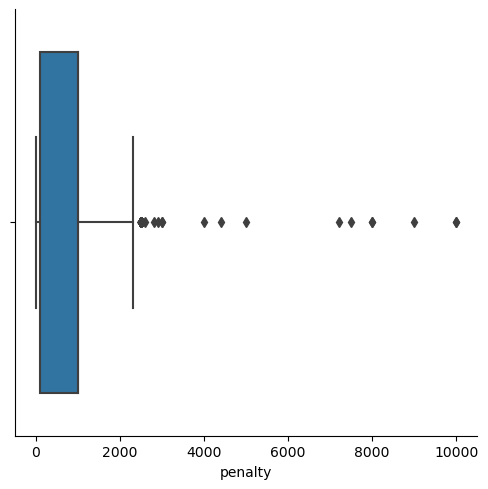

In [510]:
# Box plot of the penalty amounts
sns.catplot(x="penalty", kind="box", data=violations_data)
plt.savefig("boxpltpenalty.png")

In [511]:
violations_data.describe(include="all")

facilityname  \
count                        950   
unique                       548   
top     GAITHERSBURG SUPERMARKET   
freq                          11   
first                        NaN   
last                         NaN   
mean                         NaN   
std                          NaN   
min                          NaN   
25%                          NaN   
50%                          NaN   
75%                          NaN   
max                          NaN   

                                                 address        violationdate  \
count                                                950                  950   
unique                                               586                  344   
top     220 EAST DIAMOND AVENUE , GAITHERSBURG, MD 20877  2018-08-17 00:00:00   
freq                                                  11                   16   
first                                                NaN  2012-06-19 00:00:00   
last                                                 NaN  2020-10-31 00:00:00   
mean                                                 NaN                  NaN   
std                                                  NaN                  NaN   
min                                                  NaN                  NaN   
25%                                                  NaN                  NaN   
50%                                                  NaN                  NaN   
75%                                                  NaN                  NaN   
max                                                  NaN                  NaN   

            violation                disposition      dispositiondate  \
count             950                        948                  947   
unique              8                        146                  409   
top     SALE TO MINOR  SETTLED; $1000.00 + ALERT  2020-09-11 00:00:00   
freq              447                         96                   18   
first             NaN                        NaN  2016-01-19 00:00:00   
last              NaN                        NaN  2021-01-08 00:00:00   
mean              NaN                        NaN                  NaN   
std               NaN                        NaN                  NaN   
min               NaN                        NaN                  NaN   
25%               NaN                        NaN                  NaN   
50%               NaN                        NaN                  NaN   
75%               NaN                        NaN                  NaN   
max               NaN                        NaN                  NaN   

             penalty  
count     950.000000  
unique           NaN  
top              NaN  
freq             NaN  
first            NaN  
last             NaN  
mean      868.140000  
std       971.385756  
min         0.000000  
25%       100.000000  
50%      1000.000000  
75%      1000.000000  
max     10000.000000

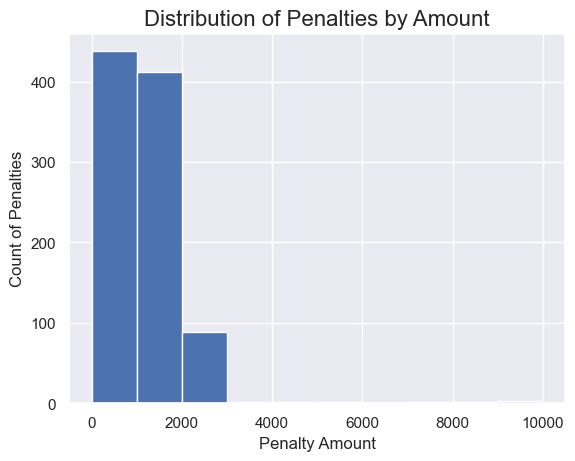

In [512]:
sns.set()
_ = plt.title("Distribution of Penalties by Amount", size=16)
_ = plt.hist(violations_data['penalty'])
_ = plt.xlabel('Penalty Amount')
_ = plt.ylabel('Count of Penalties')
plt.savefig("DistribPenaltyAmts.png")
plt.show()

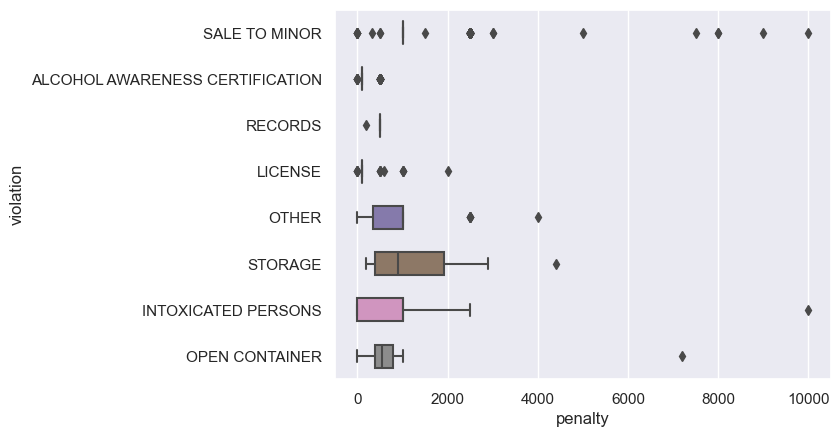

In [513]:
# box plot categorical vars
#plt.figure(figsize=(20,50))
# https://datavizpyr.com/sort-bars-in-barplot-using-seaborn-in-python/
sns.boxplot(y="violation", x="penalty", width=0.5,data=violations_data.sort_values("violation"), orient='h', order = ["SALE TO MINOR","ALCOHOL AWARENESS CERTIFICATION","RECORDS","LICENSE","OTHER","STORAGE","INTOXICATED PERSONS","OPEN CONTAINER"])
plt.savefig("BoxPlotViolations.png")

In [514]:
"""
Explore violations by zip code
"""

'\nExplore violations by zip code\n'

In [515]:
# Copy the license violations zip codes into a separate var.
# Use a regular expression to pull out the zip codes.
violations_data["zip"]=violations_data["address"].str.extract(r"((?<=.)\d{5})")
# positive lookbehind, matches to digits exactly 5 long

violations_data["zip"]=violations_data["zip"].astype(int)
violations_data

facilityname  \
0                            AMY TEX MEX BAR & GRILL   
1                                    EL CARACOL CAFE   
2                                         A.C. GRILL   
3                               ANTOJITOS RESTAURANT   
4                             CANCUN MEXICAN CUISINE   
5                             CANCUN MEXICAN CUISINE   
6                                HAKUNA MATATA GRILL   
7                               MOGOTILLO RESTAURANT   
8                                    EL CARACOL CAFE   
9                               MOGOTILLO RESTAURANT   
10                              MOGOTILLO RESTAURANT   
11                              MOGOTILLO RESTAURANT   
12                           GISELE'S CREOLE CUISINE   
13                            CASPIAN HOUSE OF KABOB   
14                            CASPIAN HOUSE OF KABOB   
15                               VILLAGE WEST LIQUOR   
16                           Q' VIVA COCINA & LOUNGE   
17                         FINNEGAN'S WAKE IRISH PUB   
18                             CUBANO'S RESTAURANT 2   
19                             CUBANO'S RESTAURANT 2   
20                             BLACK'S BAR & KITCHEN   
21                             BLACK'S BAR & KITCHEN   
22                                         BRICKSIDE   
23                               DOG HAUS BIERGARTEN   
24                                             JALEO   
25                                      MON AMI GABI   
26                              TIA QUETA RESTAURANT   
27                                   WOODMONT MARKET   
28                                     KOREAN KORNER   
29                                     KOREAN KORNER   
30                OUTBACK STEAKHOUSE - SILVER SPRING   
31                         RINCON MAGICO BAR & GRILL   
32                         RINCON MAGICO BAR & GRILL   
33                            RODMANS PARTY BOUTIQUE   
34                            RODMANS PARTY BOUTIQUE   
35                          SOLE D'ITALIA RESTAURANT   
36                           SHOPPERS FOOD WAREHOUSE   
37                                            DRYBAR   
38                                 DOLLAR PLUS STORE   
39                               HAKUNA MATATA GRILL   
40                                 STAINED GLASS PUB   
41                                     SUPER CHICKEN   
42                                  CAVA MEZZE-OLNEY   
43                              EMPIRE CAFE & MARKET   
44                                     MANNEQUIN PIS   
45                                      ROOTS MARKET   
46                                     SMOKETOWN BBQ   
47                           THE MANOR AT SILO FALLS   
48                        DENISE MEXICAN BAR & GRILL   
49                                            KABUTO   
50                                        WASABI ZEN   
51                           ARIA, BEER, WINE & DELI   
52                           ARIA, BEER, WINE & DELI   
53                                   BETHESDA MARKET   
54                               LANCE'S BEER & WINE   
55                               LANCE'S BEER & WINE   
56                          PASSION FIN ASIAN BISTRO   
57                          PASSION FIN ASIAN BISTRO   
58                          PASSION FIN ASIAN BISTRO   
59                           PROMENADE MARKET & DELI   
60                                      SUSHI OISHII   
61                                         LA CASITA   
62                                TACO DADDY CANTINA   
63                                       CASA OAXACA   
64                        CHERCHER ETHIOPIAN CUISINE   
65                                HIMALAYAN HERITAGE   
66                            MAMMA LUCIA - BETHESDA   
67                                       MEDIUM RARE   
68                        REDMILL MARKET BEER & WINE   
69                                      THAI CUISINE   
70                                               VUK   
71      

In [516]:
pd.set_option("display.max_colwidth", None)
addr=violations_data["address"].astype(str)
mask=addr.str.slice(-5,-4,1) == "-"

In [517]:
# QA the slicing for zip.
violations_data.loc[mask, ["address","zip"]]

address    zip
283  3701 UNIVERSITY BLVD. W. , KENSINGTON, MD 20895-2123  20895
448    2211 UNIVERSITY BLVD. W. B, WHEATON, MD 20902-4505  20902
531   1339 LAMBERTON DRIVE , SILVER SPRING, MD 20902-3414  20902
541   11407 LOCKWOOD DRIVE , SILVER SPRING, MD 20904-2610  20904
589        19950 FISHER AVE. , POOLESVILLE, MD 20837-2076  20837
604        4906 SAINT ELMO AVE. , BETHESDA, MD 20814-6008  20814
605          4958 BETHESDA AVE. , BETHESDA, MD 20814-5204  20814
630  3701 UNIVERSITY BLVD. W. , KENSINGTON, MD 20895-2123  20895
642       15209 FREDERICK ROAD , ROCKVILLE, MD 20850-1112  20850
718           12351 GEORGIA AVE. , WHEATON, MD 20906-3649  20906
719           12351 GEORGIA AVE. , WHEATON, MD 20906-3649  20906
731     14324 LAYHILL ROAD , SILVER SPRING, MD 20906-1909  20906
844        701 RUSSELL AVE. , GAITHERSBURG, MD 20877-2612  20877
845        701 RUSSELL AVE. , GAITHERSBURG, MD 20877-2612  20877
878   536 FOREST GLEN ROAD , SILVER SPRING, MD 20901-2206  20901

In [518]:
violations_data["address"]

0                         621 SLIGO AVE. , SILVER SPRING , MARYLAND - 20910
1                          609 SLIGO AVE , SILVER SPRING , MARYLAND - 20910
2                   293 MUDDY BRANCH ROAD , GAITHERSBURG , MARYLAND - 20878
3                    12 EAST DIAMOND AVE. , GAITHERSBURG , MARYLAND - 20877
4                    117 EAST DIAMOND AVE , GAITHERSBURG , MARYLAND - 20877
5                    117 EAST DIAMOND AVE , GAITHERSBURG , MARYLAND - 20877
6                        2405 PRICE AVE. , SILVER SPRING , MARYLAND - 20902
7                   7637 NEW HAMPSHIRE AVE , TAKOMA PARK , MARYLAND - 20912
8                          609 SLIGO AVE , SILVER SPRING , MARYLAND - 20910
9                   7637 NEW HAMPSHIRE AVE , TAKOMA PARK , MARYLAND - 20912
10                  7637 NEW HAMPSHIRE AVE , TAKOMA PARK , MARYLAND - 20912
11                  7637 NEW HAMPSHIRE AVE , TAKOMA PARK , MARYLAND - 20912
12                     2407 PRICE AVENUE , SILVER SPRING , MARYLAND - 20902
13          

In [519]:
violations_data

facilityname  \
0                            AMY TEX MEX BAR & GRILL   
1                                    EL CARACOL CAFE   
2                                         A.C. GRILL   
3                               ANTOJITOS RESTAURANT   
4                             CANCUN MEXICAN CUISINE   
5                             CANCUN MEXICAN CUISINE   
6                                HAKUNA MATATA GRILL   
7                               MOGOTILLO RESTAURANT   
8                                    EL CARACOL CAFE   
9                               MOGOTILLO RESTAURANT   
10                              MOGOTILLO RESTAURANT   
11                              MOGOTILLO RESTAURANT   
12                           GISELE'S CREOLE CUISINE   
13                            CASPIAN HOUSE OF KABOB   
14                            CASPIAN HOUSE OF KABOB   
15                               VILLAGE WEST LIQUOR   
16                           Q' VIVA COCINA & LOUNGE   
17                         FINNEGAN'S WAKE IRISH PUB   
18                             CUBANO'S RESTAURANT 2   
19                             CUBANO'S RESTAURANT 2   
20                             BLACK'S BAR & KITCHEN   
21                             BLACK'S BAR & KITCHEN   
22                                         BRICKSIDE   
23                               DOG HAUS BIERGARTEN   
24                                             JALEO   
25                                      MON AMI GABI   
26                              TIA QUETA RESTAURANT   
27                                   WOODMONT MARKET   
28                                     KOREAN KORNER   
29                                     KOREAN KORNER   
30                OUTBACK STEAKHOUSE - SILVER SPRING   
31                         RINCON MAGICO BAR & GRILL   
32                         RINCON MAGICO BAR & GRILL   
33                            RODMANS PARTY BOUTIQUE   
34                            RODMANS PARTY BOUTIQUE   
35                          SOLE D'ITALIA RESTAURANT   
36                           SHOPPERS FOOD WAREHOUSE   
37                                            DRYBAR   
38                                 DOLLAR PLUS STORE   
39                               HAKUNA MATATA GRILL   
40                                 STAINED GLASS PUB   
41                                     SUPER CHICKEN   
42                                  CAVA MEZZE-OLNEY   
43                              EMPIRE CAFE & MARKET   
44                                     MANNEQUIN PIS   
45                                      ROOTS MARKET   
46                                     SMOKETOWN BBQ   
47                           THE MANOR AT SILO FALLS   
48                        DENISE MEXICAN BAR & GRILL   
49                                            KABUTO   
50                                        WASABI ZEN   
51                           ARIA, BEER, WINE & DELI   
52                           ARIA, BEER, WINE & DELI   
53                                   BETHESDA MARKET   
54                               LANCE'S BEER & WINE   
55                               LANCE'S BEER & WINE   
56                          PASSION FIN ASIAN BISTRO   
57                          PASSION FIN ASIAN BISTRO   
58                          PASSION FIN ASIAN BISTRO   
59                           PROMENADE MARKET & DELI   
60                                      SUSHI OISHII   
61                                         LA CASITA   
62                                TACO DADDY CANTINA   
63                                       CASA OAXACA   
64                        CHERCHER ETHIOPIAN CUISINE   
65                                HIMALAYAN HERITAGE   
66                            MAMMA LUCIA - BETHESDA   
67                                       MEDIUM RARE   
68                        REDMILL MARKET BEER & WINE   
69                                      THAI CUISINE   
70                                               VUK   
71      

In [520]:
# Now I have the zip codes of the Alcohol Beverage License Violations in the var "zip".
# Do frequency of violations by zip code.

In [521]:
violations_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   facilityname     950 non-null    object        
 1   address          950 non-null    object        
 2   violationdate    950 non-null    datetime64[ns]
 3   violation        950 non-null    object        
 4   disposition      948 non-null    object        
 5   dispositiondate  947 non-null    datetime64[ns]
 6   penalty          950 non-null    int32         
 7   zip              950 non-null    int32         
dtypes: datetime64[ns](2), int32(2), object(4)
memory usage: 52.1+ KB


In [522]:
# Get counts of the number of violations by zip.
violations_data["zip"].value_counts().sort_values(ascending=False)

20814    118
20852    100
20850     97
20910     93
20878     90
20877     65
20902     63
20879     40
20874     34
20906     34
20876     23
20912     22
20904     19
20854     14
20815     14
20901     12
20832     10
20905     10
20872      9
20855      9
20851      9
20817      8
20871      8
20853      6
20903      6
20895      6
20837      5
20886      5
20816      5
20860      4
20867      2
20818      2
20882      2
20833      2
20866      2
20841      1
20861      1
Name: zip, dtype: int64

In [523]:
# Now the zips are all 5-digits
# Bethesda (20814) and Rockville (20852) have the highest frequencies. 

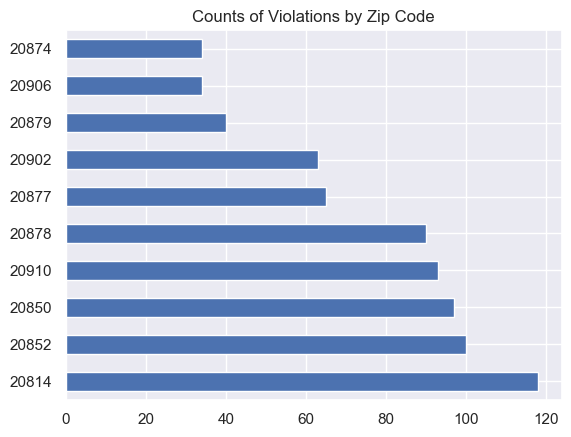

In [524]:
# This plots the top 10 most frequent zip codes. 
violations_data["zip"].value_counts()[:10].plot(kind="barh", title="Counts of Violations by Zip Code")
plt.savefig("ViolationsbyZip.png")

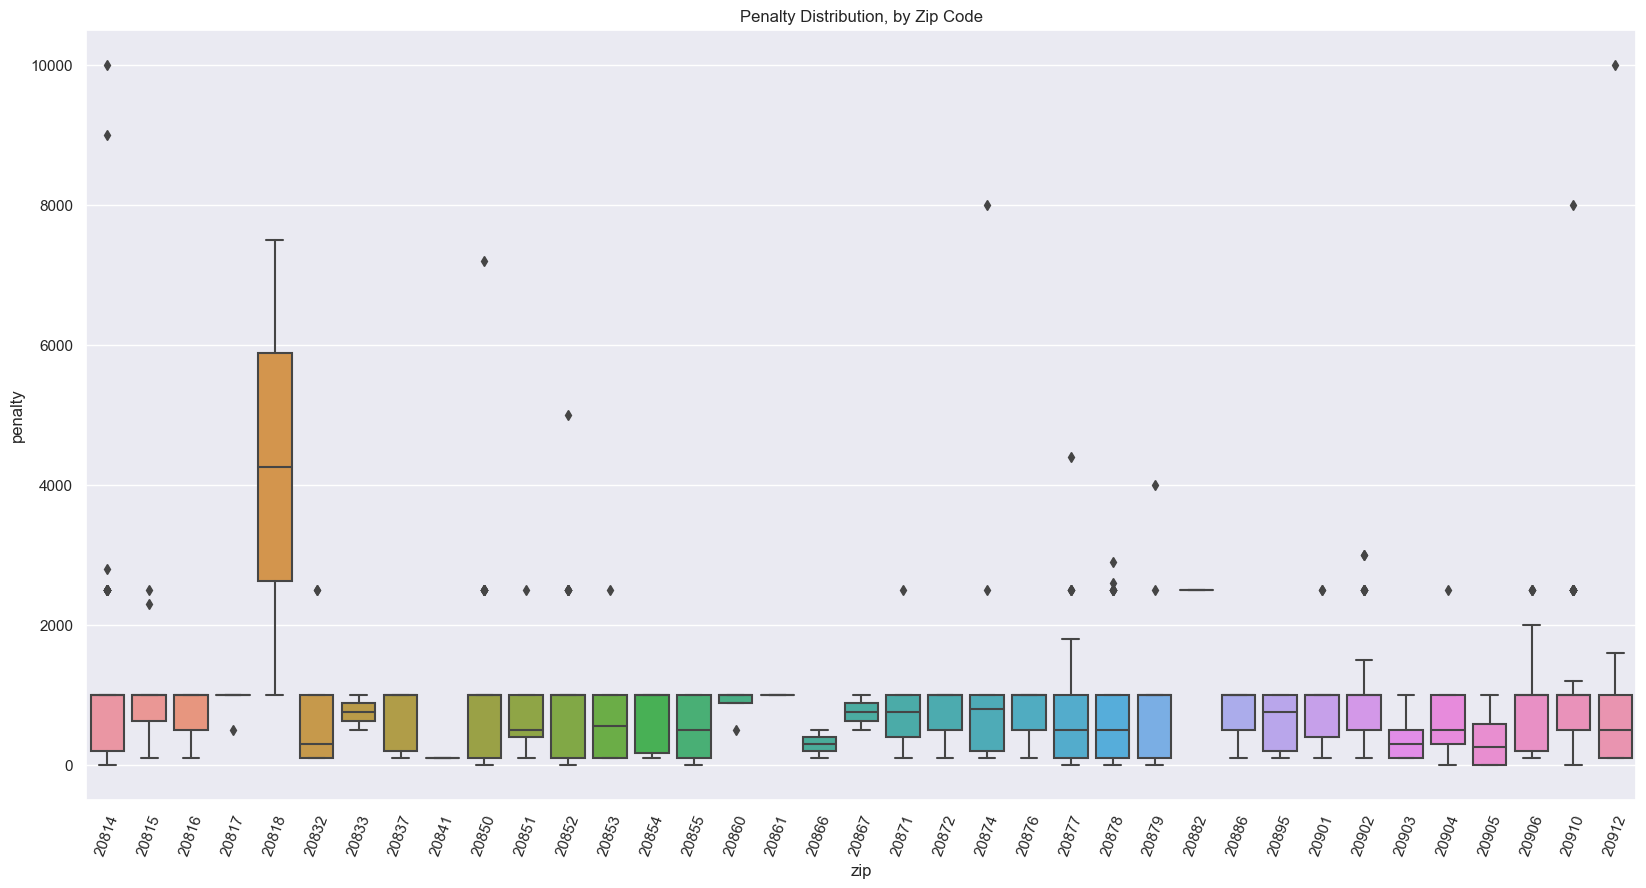

<Figure size 640x480 with 0 Axes>

In [525]:
plt.style.use("seaborn-colorblind")
plt.figure(figsize=(20,10))
sns.boxplot(x="zip", y="penalty", data=violations_data)
plt.xticks(rotation=70)

plt.title("Penalty Distribution, by Zip Code")
plt.show()
plt.savefig("ViolationsbyZipboxes.png")

In [526]:
# The identify the outliers.
violations_data[violations_data.zip.isin(["20818"])]

facilityname                                       address  \
635    BETHESDA CO-OP  6500 SEVEN LOCKS ROAD , CABIN JOHN, MD 20818   
931  CAPTAIN'S MARKET   7607 MACARTHUR BLVD. , CABIN JOHN, MD 20818   

    violationdate      violation                   disposition  \
635    2017-08-30  SALE TO MINOR        SETTLED; $1000 + ALERT   
931    2015-12-20  SALE TO MINOR  HEARING; $7,500 FINE + ALERT   

    dispositiondate  penalty    zip  
635      2017-09-21     1000  20818  
931      2016-03-17     7500  20818

In [527]:
violations_data

facilityname  \
0                            AMY TEX MEX BAR & GRILL   
1                                    EL CARACOL CAFE   
2                                         A.C. GRILL   
3                               ANTOJITOS RESTAURANT   
4                             CANCUN MEXICAN CUISINE   
5                             CANCUN MEXICAN CUISINE   
6                                HAKUNA MATATA GRILL   
7                               MOGOTILLO RESTAURANT   
8                                    EL CARACOL CAFE   
9                               MOGOTILLO RESTAURANT   
10                              MOGOTILLO RESTAURANT   
11                              MOGOTILLO RESTAURANT   
12                           GISELE'S CREOLE CUISINE   
13                            CASPIAN HOUSE OF KABOB   
14                            CASPIAN HOUSE OF KABOB   
15                               VILLAGE WEST LIQUOR   
16                           Q' VIVA COCINA & LOUNGE   
17                         FINNEGAN'S WAKE IRISH PUB   
18                             CUBANO'S RESTAURANT 2   
19                             CUBANO'S RESTAURANT 2   
20                             BLACK'S BAR & KITCHEN   
21                             BLACK'S BAR & KITCHEN   
22                                         BRICKSIDE   
23                               DOG HAUS BIERGARTEN   
24                                             JALEO   
25                                      MON AMI GABI   
26                              TIA QUETA RESTAURANT   
27                                   WOODMONT MARKET   
28                                     KOREAN KORNER   
29                                     KOREAN KORNER   
30                OUTBACK STEAKHOUSE - SILVER SPRING   
31                         RINCON MAGICO BAR & GRILL   
32                         RINCON MAGICO BAR & GRILL   
33                            RODMANS PARTY BOUTIQUE   
34                            RODMANS PARTY BOUTIQUE   
35                          SOLE D'ITALIA RESTAURANT   
36                           SHOPPERS FOOD WAREHOUSE   
37                                            DRYBAR   
38                                 DOLLAR PLUS STORE   
39                               HAKUNA MATATA GRILL   
40                                 STAINED GLASS PUB   
41                                     SUPER CHICKEN   
42                                  CAVA MEZZE-OLNEY   
43                              EMPIRE CAFE & MARKET   
44                                     MANNEQUIN PIS   
45                                      ROOTS MARKET   
46                                     SMOKETOWN BBQ   
47                           THE MANOR AT SILO FALLS   
48                        DENISE MEXICAN BAR & GRILL   
49                                            KABUTO   
50                                        WASABI ZEN   
51                           ARIA, BEER, WINE & DELI   
52                           ARIA, BEER, WINE & DELI   
53                                   BETHESDA MARKET   
54                               LANCE'S BEER & WINE   
55                               LANCE'S BEER & WINE   
56                          PASSION FIN ASIAN BISTRO   
57                          PASSION FIN ASIAN BISTRO   
58                          PASSION FIN ASIAN BISTRO   
59                           PROMENADE MARKET & DELI   
60                                      SUSHI OISHII   
61                                         LA CASITA   
62                                TACO DADDY CANTINA   
63                                       CASA OAXACA   
64                        CHERCHER ETHIOPIAN CUISINE   
65                                HIMALAYAN HERITAGE   
66                            MAMMA LUCIA - BETHESDA   
67                                       MEDIUM RARE   
68                        REDMILL MARKET BEER & WINE   
69                                      THAI CUISINE   
70                                               VUK   
71      

In [528]:
find_outlier = violations_data

In [529]:
update_find_outlier = find_outlier.drop([find_outlier.index[635], find_outlier.index[931]])

In [530]:
plt.style.use("seaborn-colorblind")
plt.figure(figsize=(20,10))
sns.boxplot(x="zip", y="penalty", data=update_find_outlier)
plt.xticks(rotation=70)

plt.title("Penalty Distribution, by Zip Code")
plt.show()
plt.savefig("ViolationsbyZipboxes2.png")

<Figure size 640x480 with 0 Axes>

In [531]:
"""
Explore the violations involving minors.
"""

'\nExplore the violations involving minors.\n'

In [532]:
# Investigate frequencies by types of violations. 
# Group the sale to minor and 6.1 sales or service to minors. 

In [533]:
# Groupby() function to pull the 2 violations together.
violations_minors = violations_data.groupby("violation").get_group("SALE TO MINOR" or "6.1 SALES OR SERVICE TO MINORS/CONSUMPTION OR POSSESSION OF MINORS")

In [534]:
violations_minors

facilityname  \
21                             BLACK'S BAR & KITCHEN   
22                                         BRICKSIDE   
23                               DOG HAUS BIERGARTEN   
24                                             JALEO   
25                                      MON AMI GABI   
26                              TIA QUETA RESTAURANT   
27                                   WOODMONT MARKET   
29                                     KOREAN KORNER   
30                OUTBACK STEAKHOUSE - SILVER SPRING   
31                         RINCON MAGICO BAR & GRILL   
35                          SOLE D'ITALIA RESTAURANT   
38                                 DOLLAR PLUS STORE   
39                               HAKUNA MATATA GRILL   
40                                 STAINED GLASS PUB   
41                                     SUPER CHICKEN   
42                                  CAVA MEZZE-OLNEY   
43                              EMPIRE CAFE & MARKET   
44                                     MANNEQUIN PIS   
45                                      ROOTS MARKET   
46                                     SMOKETOWN BBQ   
47                           THE MANOR AT SILO FALLS   
52                           ARIA, BEER, WINE & DELI   
53                                   BETHESDA MARKET   
55                               LANCE'S BEER & WINE   
56                          PASSION FIN ASIAN BISTRO   
59                           PROMENADE MARKET & DELI   
63                                       CASA OAXACA   
64                        CHERCHER ETHIOPIAN CUISINE   
65                                HIMALAYAN HERITAGE   
66                            MAMMA LUCIA - BETHESDA   
67                                       MEDIUM RARE   
70                                               VUK   
71                                   A BITE OF CHINA   
73               BETHESDA N. MARRIOTT HOTEL/CONF CTR   
74                                            KABUTO   
77                                       TEMARI CAFE   
84                            CLYDE'S OF CHEVY CHASE   
86                                 MEIWAH RESTAURANT   
87               P.F. CHANG'S CHINA BISTRO - C/CHASE   
88                             THE LITTLE BEET TABLE   
89                                          BURGERIM   
90                           FLOR DE LUNA RESTAURANT   
91                        QUINCYS SOUTH BAR & GRILLE   
92                                      SISTERS THAI   
94                                        BALDUCCI'S   
95                               COMMONWEALTH INDIAN   
98                             FLOWER CHILD-BETHESDA   
99                                      FOGO DE CHAO   
100                        MORTON'S - THE STEAKHOUSE   
101                                 WILDWOOD KITCHEN   
103                           WORLD OF BEER-BETHESDA   
108                           CAFE DELUXE - BETHESDA   
109              FLANAGAN'S HARP & FIDDLE RESTAURANT   
110                     HANARO RESTAURANT AND LOUNGE   
111                                MATCHBOX-BETHESDA   
112                                PIEOLOGY-BETHESDA   
113                                          SATSUMA   
114                               THE BETHESDA BAZAR   
115                               TRATTORIA SORRENTO   
116                                      ON THE VINE   
118                           THE BEER & WINE CELLAR   
119                                         TIA OCHI   
122                              URBAN BAR-B-QUE CO.   
129                             6/12 CONVENIENT MART   
131                            EL ESTERON RESTAURANT   
132                                    GRAPE & GRAIN   
136                              AKIRA RAMEN IZAKAYA   
137                                         BURGERFI   
138                                         GYROLAND   
141                             OM INDIAN RESTAURANT   
142                              PIKE CHICKEN & BEER   
145     

In [535]:
type(violations_minors)

pandas.core.frame.DataFrame

In [536]:
violations_minors.describe(include="all")

facilityname  \
count                     447   
unique                    403   
top     COURTYARD BY MARRIOTT   
freq                        4   
first                     NaN   
last                      NaN   
mean                      NaN   
std                       NaN   
min                       NaN   
25%                       NaN   
50%                       NaN   
75%                       NaN   
max                       NaN   

                                                 address        violationdate  \
count                                                447                  447   
unique                                               421                  129   
top     4820 BOILING BROOK PARKWAY , ROCKVILLE, MD 20852  2018-08-14 00:00:00   
freq                                                   4                   10   
first                                                NaN  2012-12-20 00:00:00   
last                                                 NaN  2020-03-12 00:00:00   
mean                                                 NaN                  NaN   
std                                                  NaN                  NaN   
min                                                  NaN                  NaN   
25%                                                  NaN                  NaN   
50%                                                  NaN                  NaN   
75%                                                  NaN                  NaN   
max                                                  NaN                  NaN   

            violation                disposition      dispositiondate  \
count             447                        447                  447   
unique              1                         62                  264   
top     SALE TO MINOR  SETTLED; $1000.00 + ALERT  2020-03-28 00:00:00   
freq              447                         89                   11   
first             NaN                        NaN  2016-01-19 00:00:00   
last              NaN                        NaN  2020-09-11 00:00:00   
mean              NaN                        NaN                  NaN   
std               NaN                        NaN                  NaN   
min               NaN                        NaN                  NaN   
25%               NaN                        NaN                  NaN   
50%               NaN                        NaN                  NaN   
75%               NaN                        NaN                  NaN   
max               NaN                        NaN                  NaN   

             penalty           zip  
count     447.000000    447.000000  
unique           NaN           NaN  
top              NaN           NaN  
freq             NaN           NaN  
first            NaN           NaN  
last             NaN           NaN  
mean     1341.908277  20864.109620  
std       991.488464     32.568645  
min         0.000000  20814.000000  
25%      1000.000000  20850.000000  
50%      1000.000000  20871.000000  
75%      1000.000000  20898.000000  
max     10000.000000  20912.000000

In [537]:
# Get counts of the number of minors violations by zip.
violations_minors["zip"].value_counts().sort_values(ascending=False)

20814    69
20852    55
20910    48
20850    43
20878    31
20902    28
20877    22
20874    17
20879    14
20876    14
20906    13
20854    10
20815     9
20904     7
20817     7
20901     7
20912     6
20872     4
20832     4
20871     4
20855     4
20837     3
20860     3
20853     3
20886     3
20851     3
20816     3
20882     2
20833     2
20818     2
20905     2
20895     2
20867     1
20861     1
20903     1
Name: zip, dtype: int64

In [538]:
# This plots top 20 zip codes for the violations involving minors.
violations_minors["zip"].value_counts()[:20].plot(kind="barh")
plt.savefig("top20zips-minors.png")

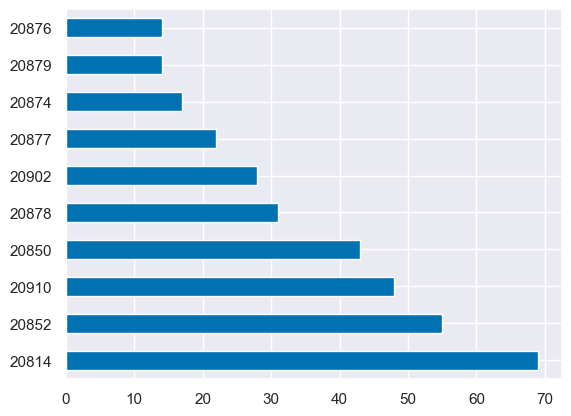

In [539]:
violations_minors["zip"].value_counts()[:10].plot(kind="barh")
plt.savefig("top10zips-minors.png")

In [540]:
# From Professor: 
mask_minors = violations_data["violation"] == ("SALE TO MINOR" or "6.1 SALES OR SERVICE TO MINORS/CONSUMPTION OR POSSESSION OF MINORS")
violations_data["zip_minors"] = mask_minors

In [541]:
# From Professor: 
violations_data[["violation", "zip", "zip_minors"]]

violation    zip  zip_minors
0                              OTHER  20910       False
1                              OTHER  20910       False
2    ALCOHOL AWARENESS CERTIFICATION  20878       False
3                INTOXICATED PERSONS  20877       False
4                              OTHER  20877       False
5                              OTHER  20877       False
6                              OTHER  20902       False
7                            RECORDS  20912       False
8                            LICENSE  20910       False
9                            RECORDS  20912       False
10                           LICENSE  20912       False
11                           STORAGE  20912       False
12                           STORAGE  20902       False
13                           RECORDS  20878       False
14   ALCOHOL AWARENESS CERTIFICATION  20878       False
15                           RECORDS  20876       False
16                             OTHER  20902       False
17                             OTHER  20850       False
18   ALCOHOL AWARENESS CERTIFICATION  20814       False
19                           RECORDS  20814       False
20                           LICENSE  20814       False
21                     SALE TO MINOR  20814        True
22                     SALE TO MINOR  20814        True
23                     SALE TO MINOR  20814        True
24                     SALE TO MINOR  20814        True
25                     SALE TO MINOR  20814        True
26                     SALE TO MINOR  20814        True
27                     SALE TO MINOR  20814        True
28   ALCOHOL AWARENESS CERTIFICATION  20906       False
29                     SALE TO MINOR  20906        True
30                     SALE TO MINOR  20906        True
31                     SALE TO MINOR  20906        True
32                           RECORDS  20906       False
33   ALCOHOL AWARENESS CERTIFICATION  20906       False
34               INTOXICATED PERSONS  20906       False
35                     SALE TO MINOR  20906        True
36   ALCOHOL AWARENESS CERTIFICATION  20874       False
37                           LICENSE  20814       False
38                     SALE TO MINOR  20902        True
39                     SALE TO MINOR  20902        True
40                     SALE TO MINOR  20906        True
41                     SALE TO MINOR  20902        True
42                     SALE TO MINOR  20832        True
43                     SALE TO MINOR  20833        True
44                     SALE TO MINOR  20832        True
45                     SALE TO MINOR  20832        True
46                     SALE TO MINOR  20860        True
47                     SALE TO MINOR  20833        True
48                           RECORDS  20871       False
49   ALCOHOL AWARENESS CERTIFICATION  20850       False
50   ALCOHOL AWARENESS CERTIFICATION  20832       False
51                           LICENSE  20814       False
52                     SALE TO MINOR  20814        True
53                     SALE TO MINOR  20816        True
54                             OTHER  20814       False
55                     SALE TO MINOR  20814        True
56                     SALE TO MINOR  20816        True
57                           LICENSE  20816       False
58                           RECORDS  20816       False
59                     SALE TO MINOR  20814        True
60   ALCOHOL AWARENESS CERTIFICATION  20850       False
61   ALCOHOL AWARENESS CERTIFICATION  20877       False
62   ALCOHOL AWARENESS CERTIFICATION  20878       False
63                     SALE TO MINOR  20814        True
64                     SALE TO MINOR  20814        True
65                     SALE TO MINOR  20814        True
66                     SALE TO MINOR  20814        True
67                     SALE TO MINOR  20814        True
68   ALCOHOL AWARENESS CERTIFICATION  20855       False
69   ALCOHOL AWARENESS CERTIFICATION  20832       False
70                     SALE TO MINOR  20814        

In [542]:
# From Professor: 
zip_minor_violations = violations_data[["zip", "zip_minors"]].groupby(["zip"], as_index=False).sum()
zip_violations = violations_data[["zip", "violation"]].groupby(["zip"], as_index=False).count()
zip_minor_violations = zip_minor_violations.merge(zip_violations, on="zip")
zip_minor_violations.sort_values(ascending=False,by=["violation","zip"])

zip  zip_minors  violation
0   20814        69.0        118
11  20852        55.0        100
9   20850        43.0         97
35  20910        48.0         93
24  20878        31.0         90
23  20877        22.0         65
30  20902        28.0         63
25  20879        14.0         40
34  20906        13.0         34
21  20874        17.0         34
22  20876        14.0         23
36  20912         6.0         22
32  20904         7.0         19
13  20854        10.0         14
1   20815         9.0         14
29  20901         7.0         12
33  20905         2.0         10
5   20832         4.0         10
20  20872         4.0          9
14  20855         4.0          9
10  20851         3.0          9
19  20871         4.0          8
3   20817         7.0          8
31  20903         1.0          6
28  20895         2.0          6
12  20853         3.0          6
27  20886         3.0          5
7   20837         3.0          5
2   20816         3.0          5
15  20860         3.0          4
26  20882         2.0          2
18  20867         1.0          2
17  20866         0.0          2
6   20833         2.0          2
4   20818         2.0          2
16  20861         1.0          1
8   20841         0.0          1

In [543]:
# From Professor
plt.rcdefaults() #resets default chart style to not pick up previous chart style
plt.style.use("fivethirtyeight")
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(1,1,1)

bar_1 = range(len(zip_minor_violations["violation"]))
ax.bar(bar_1, zip_minor_violations["violation"], label="Non Minor-Related Violations")
ax.bar(bar_1, zip_minor_violations["zip_minors"], bottom=zip_minor_violations["violation"], label="Minor-Related Violations")
plt.xticks(range(len(zip_minor_violations["zip"])), zip_minor_violations["zip"], rotation=90)
plt.legend(loc="upper right")
plt.title("Minor-Related Violations vs. Non Minor-Related Violations, by Zip Code")
plt.show()
plt.savefig("minors.vs.nonbyzip.png")

<Figure size 640x480 with 0 Axes>

In [544]:
# My Michael suggests changing this to porportion by minors. instead of count. 
# b/c we don't care about counts but the % that relate to minors. 

In [545]:
# https://benalexkeen.com/bar-charts-in-matplotlib/
# https://stackoverflow.com/questions/52080991/display-percentage-above-bar-chart-in-matplotlib

# calculate the percentage of minors violations to the whole violations
#result_pct = np.true_divide(zip_minor_violations["violation"],violations_data["zip"])*100
#result_pct

In [546]:
zip_minor_violations.head()

zip  zip_minors  violation
0  20814        69.0        118
1  20815         9.0         14
2  20816         3.0          5
3  20817         7.0          8
4  20818         2.0          2

In [547]:
violations_minors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447 entries, 21 to 946
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   facilityname     447 non-null    object        
 1   address          447 non-null    object        
 2   violationdate    447 non-null    datetime64[ns]
 3   violation        447 non-null    object        
 4   disposition      447 non-null    object        
 5   dispositiondate  447 non-null    datetime64[ns]
 6   penalty          447 non-null    int32         
 7   zip              447 non-null    int32         
dtypes: datetime64[ns](2), int32(2), object(4)
memory usage: 27.9+ KB


In [548]:
violations_minors.head()

facilityname                                             address  \
21  BLACK'S BAR & KITCHEN     7750 WOODMONT AVE , BETHESDA , MARYLAND - 20814   
22              BRICKSIDE      4866 CORDELL AVE , BETHESDA , MARYLAND - 20814   
23    DOG HAUS BIERGARTEN  7904 WOODMONT AVENUE , BETHESDA , MARYLAND - 20814   
24                  JALEO     7271 WOODMONT AVE , BETHESDA , MARYLAND - 20814   
25           MON AMI GABI     7239 WOODMONT AVE , BETHESDA , MARYLAND - 20814   

   violationdate      violation           disposition dispositiondate  \
21    2020-03-12  SALE TO MINOR          $2500 +ALERT      2020-09-11   
22    2020-03-12  SALE TO MINOR  SETTLED $1000 +ALERT      2020-09-11   
23    2020-03-12  SALE TO MINOR  SETTLED $1000 +ALERT      2020-09-11   
24    2020-03-12  SALE TO MINOR  SETTLED $1000 +ALERT      2020-09-11   
25    2020-03-12  SALE TO MINOR  SETTLED $1000 +ALERT      2020-09-11   

    penalty    zip  
21     2500  20814  
22     1000  20814  
23     1000  20814  
24     1000  20814  
25     1000  20814

In [549]:
# set up the ANOVA model (analysis of variance) 
# ANOVA analyzes the differences among group means 
# The null hypothesis is that there is no statistically significant difference in the means across the zip codes.
# (Null rephrased: there is no statistically significant difference in the means of the penalty amounts by zip code.)

anovamodel = ols(formula = "penalty ~ zip", data = violations_minors).fit()
print(anovamodel.summary())

                            OLS Regression Results                            
Dep. Variable:                penalty   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                   0.01237
Date:                Mon, 14 Dec 2020   Prob (F-statistic):              0.912
Time:                        10:42:55   Log-Likelihood:                -3717.7
No. Observations:                 447   AIC:                             7439.
Df Residuals:                     445   BIC:                             7448.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2006.2174   3.01e+04     -0.067      0.9

In [550]:
anova_table = sm.stats.anova_lm(anovamodel, type = 2)
print(anova_table)

             df        sum_sq        mean_sq         F    PR(>F)
zip         1.0  1.218255e+04   12182.545547  0.012365  0.911509
Residual  445.0  4.384278e+08  985231.098188       NaN       NaN


In [551]:
# Tukey Post Hoc test
# this uses Tukey's honestly significant difference (hsd) test
multi_comparison = multi(violations_minors["zip"], violations_minors["penalty"])
residuals = multi_comparison.tukeyhsd()
print(residuals.summary())
# https://pythonhealthcare.org/2018/04/13/55-statistics-multi-comparison-with-tukeys-test-and-the-holm-bonferroni-method/
# https://www.csusm.edu/psychology/statistics_help/anova.html

  Multiple Comparison of Means - Tukey HSD, FWER=0.05  
group1 group2 meandiff p-adj    lower    upper   reject
-------------------------------------------------------
     0    333     11.0    0.9 -102.2143 124.2143  False
     0    500    -19.5    0.9 -104.4107  65.4107  False
     0   1000  20.7721 0.8622  -19.6524  61.1965  False
     0   1500     59.0 0.8473  -54.2143 172.2143  False
     0   2500  25.6104   0.66  -16.1968  67.4175  False
     0   3000     59.0 0.4912  -25.9107 143.9107  False
     0   5000      9.0    0.9 -104.2143 122.2143  False
     0   7500    -25.0    0.9 -138.2143  88.2143  False
     0   8000     49.0 0.7327  -35.9107 133.9107  False
     0   9000    -29.0    0.9 -142.2143  84.2143  False
     0  10000    -29.0    0.9 -142.2143  84.2143  False
   333    500    -30.5    0.9 -160.2032  99.2032  False
   333   1000   9.7721    0.9  -96.2809 115.8251  False
   333   1500     48.0    0.9 -101.7684 197.7684  False
   333   2500  14.6104    0.9  -91.9773 121.1981

In [553]:
# This ANOVA test says that we need to accept the null hypothesis.
# There is no statistically signficant difference in the means of penalty amounts based on zip code.

In [554]:
#df = df[df['my_col'].notnull()].copy()
#df.loc[:, 'my_col'] = df['my_col'].astype(int).astype(str)
    #df['my_col'] = df['my_col'].astype(int).astype(str) # works too!
    


In [555]:
violations_minors2 = violations_minors[violations_minors["zip"].notnull()].copy()
violations_minors2.loc[:, "zip"] = violations_minors2["zip"].astype(int).astype(str)

In [556]:
violations_minors2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 447 entries, 21 to 946
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   facilityname     447 non-null    object        
 1   address          447 non-null    object        
 2   violationdate    447 non-null    datetime64[ns]
 3   violation        447 non-null    object        
 4   disposition      447 non-null    object        
 5   dispositiondate  447 non-null    datetime64[ns]
 6   penalty          447 non-null    int32         
 7   zip              447 non-null    object        
dtypes: datetime64[ns](2), int32(1), object(5)
memory usage: 29.7+ KB


In [557]:
violations_minors2.head()

facilityname                                             address  \
21  BLACK'S BAR & KITCHEN     7750 WOODMONT AVE , BETHESDA , MARYLAND - 20814   
22              BRICKSIDE      4866 CORDELL AVE , BETHESDA , MARYLAND - 20814   
23    DOG HAUS BIERGARTEN  7904 WOODMONT AVENUE , BETHESDA , MARYLAND - 20814   
24                  JALEO     7271 WOODMONT AVE , BETHESDA , MARYLAND - 20814   
25           MON AMI GABI     7239 WOODMONT AVE , BETHESDA , MARYLAND - 20814   

   violationdate      violation           disposition dispositiondate  \
21    2020-03-12  SALE TO MINOR          $2500 +ALERT      2020-09-11   
22    2020-03-12  SALE TO MINOR  SETTLED $1000 +ALERT      2020-09-11   
23    2020-03-12  SALE TO MINOR  SETTLED $1000 +ALERT      2020-09-11   
24    2020-03-12  SALE TO MINOR  SETTLED $1000 +ALERT      2020-09-11   
25    2020-03-12  SALE TO MINOR  SETTLED $1000 +ALERT      2020-09-11   

    penalty    zip  
21     2500  20814  
22     1000  20814  
23     1000  20814  
24     1000  20814  
25     1000  20814

In [561]:
viols = violations_minors.get("violation")
viols

21     SALE TO MINOR
22     SALE TO MINOR
23     SALE TO MINOR
24     SALE TO MINOR
25     SALE TO MINOR
26     SALE TO MINOR
27     SALE TO MINOR
29     SALE TO MINOR
30     SALE TO MINOR
31     SALE TO MINOR
35     SALE TO MINOR
38     SALE TO MINOR
39     SALE TO MINOR
40     SALE TO MINOR
41     SALE TO MINOR
42     SALE TO MINOR
43     SALE TO MINOR
44     SALE TO MINOR
45     SALE TO MINOR
46     SALE TO MINOR
47     SALE TO MINOR
52     SALE TO MINOR
53     SALE TO MINOR
55     SALE TO MINOR
56     SALE TO MINOR
59     SALE TO MINOR
63     SALE TO MINOR
64     SALE TO MINOR
65     SALE TO MINOR
66     SALE TO MINOR
67     SALE TO MINOR
70     SALE TO MINOR
71     SALE TO MINOR
73     SALE TO MINOR
74     SALE TO MINOR
77     SALE TO MINOR
84     SALE TO MINOR
86     SALE TO MINOR
87     SALE TO MINOR
88     SALE TO MINOR
89     SALE TO MINOR
90     SALE TO MINOR
91     SALE TO MINOR
92     SALE TO MINOR
94     SALE TO MINOR
95     SALE TO MINOR
98     SALE TO MINOR
99     SALE T

In [562]:
stats.f_oneway(violations_minors2["penalty"][violations_minors2["zip"]==viols[0]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[1]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[2]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[3]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[4]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[5]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[6]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[7]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[8]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[9]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[10]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[11]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[12]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[13]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[14]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[15]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[16]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[17]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[18]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[19]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[20]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[21]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[22]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[23]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[24]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[25]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[26]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[27]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[28]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[29]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[30]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[31]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[32]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[33]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[34]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[35]],
               violations_minors2["penalty"][violations_minors2["zip"]==viols[36]])

KeyError: 0

In [563]:
## Taking another look using violations_data (versus violations_minors dataset)

In [564]:
violations_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   facilityname     950 non-null    object        
 1   address          950 non-null    object        
 2   violationdate    950 non-null    datetime64[ns]
 3   violation        950 non-null    object        
 4   disposition      948 non-null    object        
 5   dispositiondate  947 non-null    datetime64[ns]
 6   penalty          950 non-null    int32         
 7   zip              950 non-null    int32         
 8   zip_minors       950 non-null    bool          
dtypes: bool(1), datetime64[ns](2), int32(2), object(4)
memory usage: 53.0+ KB


In [565]:
violations_data.head()

facilityname  \
0  AMY TEX MEX BAR & GRILL   
1          EL CARACOL CAFE   
2               A.C. GRILL   
3     ANTOJITOS RESTAURANT   
4   CANCUN MEXICAN CUISINE   

                                                   address violationdate  \
0        621 SLIGO AVE. , SILVER SPRING , MARYLAND - 20910    2020-10-31   
1         609 SLIGO AVE , SILVER SPRING , MARYLAND - 20910    2020-10-31   
2  293 MUDDY BRANCH ROAD , GAITHERSBURG , MARYLAND - 20878    2020-10-29   
3   12 EAST DIAMOND AVE. , GAITHERSBURG , MARYLAND - 20877    2020-10-25   
4   117 EAST DIAMOND AVE , GAITHERSBURG , MARYLAND - 20877    2020-10-25   

                         violation   disposition dispositiondate  penalty  \
0                            OTHER  $1000 +ALERT      2021-01-08     1000   
1                            OTHER  $1000 +ALERT      2021-01-08     1000   
2  ALCOHOL AWARENESS CERTIFICATION   $100 +ALERT      2021-01-08      100   
3              INTOXICATED PERSONS  $1000 +ALERT      2021-01-08     1000   
4                            OTHER   $200 +ALERT      2021-01-08      200   

     zip  zip_minors  
0  20910       False  
1  20910       False  
2  20878       False  
3  20877       False  
4  20877       False

In [566]:
# Create values for violations
violation_value = {"SALE TO MINOR": 1,
                     "ALCOHOL AWARENESS CERTIFICATION": 2,
                     "RECORDS": 3,
                     "LICENSE": 4,
                     "OTHER": 5,
                     "STORAGE": 6,
                     "INTOXICATED PERSONS": 7,
                     "OPEN CONTAINER": 8
                     }

violations_data["viol_value"] = violations_data["violation"].map(violation_value)
                  

In [567]:
violations_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 950 entries, 0 to 949
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   facilityname     950 non-null    object        
 1   address          950 non-null    object        
 2   violationdate    950 non-null    datetime64[ns]
 3   violation        950 non-null    object        
 4   disposition      948 non-null    object        
 5   dispositiondate  947 non-null    datetime64[ns]
 6   penalty          950 non-null    int32         
 7   zip              950 non-null    int32         
 8   zip_minors       950 non-null    bool          
 9   viol_value       950 non-null    int64         
dtypes: bool(1), datetime64[ns](2), int32(2), int64(1), object(4)
memory usage: 60.4+ KB


In [568]:
violations_data.describe()

penalty           zip  viol_value
count    950.000000    950.000000  950.000000
mean     868.140000  20868.189474    2.287368
std      971.385756     31.218896    1.678774
min        0.000000  20814.000000    1.000000
25%      100.000000  20850.000000    1.000000
50%     1000.000000  20876.000000    2.000000
75%     1000.000000  20902.000000    3.000000
max    10000.000000  20912.000000    8.000000

In [569]:
# set up the ANOVA model 

anovamodel2 = ols(formula = "penalty ~ viol_value", data = violations_data).fit()
print(anovamodel2.summary())

                            OLS Regression Results                            
Dep. Variable:                penalty   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     31.93
Date:                Mon, 14 Dec 2020   Prob (F-statistic):           2.12e-08
Time:                        10:45:27   Log-Likelihood:                -7866.5
No. Observations:                 950   AIC:                         1.574e+04
Df Residuals:                     948   BIC:                         1.575e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1107.0374     52.436     21.112      0.0

In [570]:
anova_table2 = sm.stats.anova_lm(anovamodel2, type = 2)
print(anova_table2)

               df        sum_sq       mean_sq          F        PR(>F)
viol_value    1.0  2.917433e+07  2.917433e+07  31.926002  2.117540e-08
Residual    948.0  8.662928e+08  9.138110e+05        NaN           NaN


In [571]:
# Tukey Post Hoc test
multi_comparison2 = multi(violations_data["viol_value"], violations_data["penalty"])
residuals2 = multi_comparison2.tukeyhsd()
print(residuals2.summary())

 Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower    upper  reject
-----------------------------------------------------
     0    100  -1.3167  0.001   -2.174 -0.4594   True
     0    200   2.0244 0.0609  -0.0322  4.0809  False
     0    333  -2.9756    0.9  -8.0653  2.1141  False
     0    400   2.6911 0.0019    0.493  4.8891   True
     0    500  -1.1682  0.001  -2.0478 -0.2885   True
     0    600   2.4244 0.0401   0.0423  4.8065   True
     0    800   3.3577 0.0103     0.35  6.3654   True
     0   1000  -2.3531  0.001  -3.1769 -1.5292   True
     0   1200   2.0244    0.9  -3.0653  7.1141  False
     0   1500  -2.9756    0.9  -8.0653  2.1141  False
     0   1600   2.0244    0.9  -3.0653  7.1141  False
     0   1800   2.0244    0.9  -3.0653  7.1141  False
     0   2000   0.0244    0.9  -5.0653  5.1141  False
     0   2300   2.0244    0.9  -3.0653  7.1141  False
     0   2500  -2.6624  0.001  -3.6223 -1.7024   True
     0   2600   2.0244    0.

In [ ]:
"""
Explore the High Schools
"""

In [ ]:
# I may try to overlay the high school locations with areas of highest crime and/or alcohol violations. 

In [ ]:
# Import the public high schools data set.
schools_data = pd.DataFrame(requests.get("https://data.montgomerycountymd.gov/resource/772q-4wm8.json").json())
schools_data.head()

In [ ]:
# Drop the unnecessary columns (i.e., category, elementary/middle schools, phone and url).

In [ ]:
high_schools=schools_data[schools_data["category"] == "HIGH SCHOOLS"]
cols_drop=["category","phone","url"]
high_schools.drop(cols_drop, inplace=True, axis=1)
print(high_schools)

In [ ]:
# Map the high school locations.

In [ ]:
# Import the plotly express package

import plotly.express as px

fig_schools = px.scatter_geo(high_schools, 
                     lon="longitude", 
                     lat="latitude",
                     # choose the map chart's projection
                     projection="albers usa",
                     center=dict(lon=-77.14, lat=39.098),
                     # columns which is in bold in the pop up
                     hover_name = "school_name",
                     # format of the popup not to display these columns' data
                     hover_data = {"longitude": False, "latitude": False})
fig_schools.show()



In [ ]:
# I'm having trouble zooming in on this map. I decided to use a different map (below) that includes streets.

In [ ]:
# Follow instructions from here: https://plotly.com/python/mapbox-layers/#openstreetmap-tiles-no-token-needed
high_schools['latitude']=high_schools['latitude'].astype(float)
high_schools['longitude']=high_schools['longitude'].astype(float)

fig_schools_map = px.scatter_mapbox(high_schools, lat="latitude", lon="longitude", hover_name="school_name", zoom=9, 
                         hover_data={"latitude":False, "longitude":False})
fig_schools_map.update_layout(mapbox_style="open-street-map")
fig_schools_map.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig_schools_map.show()


In [ ]:
# I don't know what to do about the warnings (above)
    # A value is trying to be set on a copy of a slice from a DataFrame.
    # Try using .loc[row_indexer,col_indexer] = value instead

In [ ]:
# While this map is OK, I can't decide what would make it better. 
# I was not able to make the points/circles bigger.
# I tried zooming in closer but then not all of the high schools show up.
# I tried to get the city to display as well as the HS name but was not able to get this to work.

# I'll try to map the violations and schools using Tableau.

In [ ]:
"""
Explore mapping the violations.
"""

In [ ]:
# I was able to clean the violation addresses in excel, upload to geocodio, then use that csv to map. 
# However, I want to be able to do this directly from the dataMontgomery API. 

# I tried again for the geolocation using geopy (below) following these instructions from towardsdatascience.com.
#  https://towardsdatascience.com/pythons-geocoding-convert-a-list-of-addresses-into-a-map-f522ef513fd6
# I think there is a limit to how many times I can use the geolocater/site though. Not sure about that. 

In [ ]:
# Import the violations data set (I don't need to do this repeatedly but sometimes I am picking up here when I start again)
#violations_data = pd.DataFrame(requests.get("https://data.montgomerycountymd.gov/resource/4tja-rkhg.json").json())
#violations_data.head()

In [ ]:
# I had to pip install geopy on the cmd line to get this to work.
#from geopy.geocoders import Nominatim
#geolocator = Nominatim(user_agent="sample app")
# Apply geolocator.geocode to the address column
#violations_data["location"]=violations_data["address"].apply(geolocator.geocode)

In [ ]:
#violations_data["point"]=violations_data["location"].apply(lambda loc: tuple(loc.point) if loc else None)

In [ ]:
# Then pull the values into 3 diff vars (the 3rd one is altitude)

In [ ]:
#violations_data[["latitude", "longitude", "altitude"]] = pd.DataFrame(violations_data["point"].to_list(), index=violations_data.index)

In [ ]:
# Map the locations of the violations
#fig_violations_map = px.scatter_mapbox(violations_data, lat="latitude", lon="longitude", hover_name="facilityname", zoom=9, 
#                         hover_data={"latitude":False, "longitude":False})
#fig_violations_map.update_layout(mapbox_style="open-street-map")
#fig_violations_map.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
#fig_violations_map.show()


In [ ]:
"""
Explore CRIME data set
"""

In [ ]:
# Pull in the Crimes data
# Trying to narrow by crimes against society and then crime2 for alcohol violations. 
# looking at the crimes data, there are only 8 alcohol-related crimes in the crimes data set.
# under Crime Name 2  Drunkenness,  Driving Under the Influence,  Liquor Law Violations
#select_crime = {"crimename1": "Crime Against Society"}
crime_data = pd.read_csv("crime.csv")
crime_data.head()

In [ ]:
crime_data.info()

In [ ]:
# Drop unnecessary columns
cols_to_drop=["Offence Code","CR Number","Dispatch Date / Time","Victims","Agency","Place","Sector","Beat","PRA","Address Number","Street Prefix","Street Name","Street Suffix","Street Type","End_Date_Time"]
crime_data.drop(cols_to_drop, inplace=True, axis=1)
crime_data.info()

In [ ]:
crime_data.describe(include="all")

In [ ]:
# There are 3,187 records with blank zip codes.
# There are another 200+ with incorrect zips (wrong number of digits and/or not in Montgomery County).
# Replace missing zip codes values with 0.
crime_data["Zip Code"]=crime_data["Zip Code"].fillna(0)
# change the zip code type to an integer.
crime_data["Zip Code"]=crime_data["Zip Code"].astype(int)

# This plots top 20 zip codes for the crimes.
crime_data["Zip Code"].value_counts()[:20].plot(kind="barh", title="Counts of Crimes by Zip, Highest 20 Zip Codes")
plt.savefig("top20zipsforcrimes.png")

In [ ]:
"""
Explore Population data by zip code
"""

In [ ]:
# Pull population data from this site https://worldpopulationreview.com/zips/maryland
# This is the csv link:  blob:https://worldpopulationreview.com/00124d35-9d90-48ad-973f-a3eaddcbe13e 
# this is the json link:  blob:https://worldpopulationreview.com/eaa13b61-5379-49d2-a077-3d611a223c7b
# I downloaded MD counties with populations by zip code so I can select Montgomery County. 
# The site says it reflects 2020 population data.
# blob:https://worldpopulationreview.com/087018d8-c25a-44cf-a6d9-cb479a108878
  #      blob:https://worldpopulationreview.com/507fea65-9f1a-483d-89a4-b640e1b3e9bb

In [ ]:
pop_zip_codes = pd.read_csv('PopulationZip.csv')
pop_zip_codes.head()

In [ ]:
pop_zip_codes.info()

In [ ]:
# groupby() to pull only Montgomery County zips.
pop_zip_mont = pop_zip_codes.groupby("county").get_group("Montgomery")
pop_zip_mont

In [ ]:
pop_zip_mont.info()

In [ ]:
# Get frequency of all crimes by zip code. (crimes data set has zip code column) 
# Need to calculate violations per population by zip code and crimes per population by zip code. 
# Compare alcohol violations by zip code with crimes by zip code. 

In [ ]:
# zip codes with high crime rates and zip codes with high ABS licenses and/or violations = correlation? 
# not just look at major crimes but also petty crimes. 

# Do this by taking ABS licenses (or violations) by population by zip code? 
# Then crimes by population by zip code? 